In [2]:
cd /home/tijmen/tudelft/thesis/metaengineering

/home/tijmen/tudelft/thesis/metaengineering


In [3]:
from collections import defaultdict
from typing import DefaultDict, List

from src.pipeline.dataloader import DataLoader


import pandas as pd
import numpy as np

import cobra
from cobra.util import create_stoichiometric_matrix
from cobra.core import Reaction

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns



In [4]:
path = "/home/tijmen/tudelft/thesis/metaengineering/data"
model = cobra.io.read_sbml_model(f'{path}/iMM904.xml')

In [5]:
DataLoader.DATA_FOLDER = './data/training/'
dl = DataLoader()
protein_metabolite_df = dl.get_simple_protein_metabolite_dataframe()
ENZYMES = protein_metabolite_df.to_df().columns.to_list()

PRECURSOR_METABOLITES = [
    'g6p;g6p-B', 'g6p;f6p;g6p-B', 'f6p', 'dhap', '3pg;2pg',
    'pep', 'pyr', 'r5p', 'accoa', 'akg', 'oaa',
]

def get_gene_reaction():
    gene_to_reaction: DefaultDict[str, List[str]] = defaultdict(list)
    reaction_to_gene: DefaultDict[str, List[str]] = defaultdict(list)

    for gene in model.genes:
        if gene.id not in ENZYMES:
            continue

        for reaction in gene.reactions:
            gene_to_reaction[gene.id].append(reaction.id)
            reaction_to_gene[reaction.id].append(gene.id)
    return gene_to_reaction, reaction_to_gene

def is_precursor_metabolite(metabolite_model_id: str):
    for precursor_metabolite in PRECURSOR_METABOLITES:
        if precursor_metabolite in metabolite_model_id:
            yield precursor_metabolite

In [6]:
precursor_model_metabolites = list(filter(lambda x: any((pc_meta in x.id for pc_meta in PRECURSOR_METABOLITES)), model.metabolites))
precursor_model_metabolites_id = list(map(lambda x: x.id, precursor_model_metabolites))

precursor_stiochiometric_df: pd.DataFrame = create_stoichiometric_matrix(model, array_type="DataFrame").loc[precursor_model_metabolites_id]
precursor_stiochiometric_df = precursor_stiochiometric_df.loc[:, (precursor_stiochiometric_df != 0).any(axis=0)]
precursor_reactions: List[Reaction] = list(map(lambda x: model.reactions.get_by_id(x), precursor_stiochiometric_df.columns.to_list()))

In [7]:
precursor_reactions[0].reversibility

False

In [8]:
gene_to_reaction, reaction_to_gene = get_gene_reaction()

precursor_reactions = list(map(lambda x: (reaction_to_gene[x], precursor_stiochiometric_df[x].values), precursor_stiochiometric_df.columns.to_list()))
precursor_reactions = [(enzyme, stiochiometrie) for enzymes, stiochiometrie in precursor_reactions for enzyme in enzymes]

edge_list_df = pd.DataFrame.from_records(precursor_reactions).T
edge_list_df = edge_list_df.explode(edge_list_df.columns.to_list()).set_axis(edge_list_df.iloc[0], axis=1)
edge_list_df = edge_list_df.drop(0).set_index(precursor_stiochiometric_df.index).groupby(edge_list_df.columns, axis=1).sum()
edge_list_df = edge_list_df.stack().rename_axis(['metabolite_id', 'enzyme']).rename("cardinality")
edge_list_df = edge_list_df = edge_list_df[edge_list_df != 0].reset_index()
edge_list_df

,metabolite_id,enzyme,cardinality
0,1pyr5c_c,YER023W,-1.0
1,akg_c,YDL171C,-1.0
2,akg_c,YGL202W,-1.0
3,akg_c,YIL116W,1.0
4,akg_c,YIR034C,1.0
...,...,...,...
103,r5p_c,YKL181W,-1.0
104,r5p_c,YMR105C,1.0
105,r5p_c,YOL061W,-1.0
106,r5p_c,YOR095C,-1.0


In [9]:
# precursor_reactions = list(map(lambda x: (reaction_to_gene[x], model.reactions.get_by_id(x).reversibility), precursor_stiochiometric_df.columns.to_list()))
# precursor_reactions = [(enzyme, stiochiometrie) for enzymes, stiochiometrie in precursor_reactions for enzyme in enzymes]

# df = pd.DataFrame.from_records(precursor_reactions).T
# df = df.set_axis(df.iloc[0], axis=1)
# df = df.drop(0).set_index(precursor_stiochiometric_df.index)
# df = df.drop(0).set_index(precursor_stiochiometric_df.index).groupby(df.columns, axis=1).sum()
# df = df.stack().rename_axis(['metabolite_id', 'enzyme']).rename("cardinality")
# df = df = df[df != 0].reset_index()
# df

In [10]:
def get_matching_precursor_metabolite(cobra_metabolite_id):
    for precursor_metabolite in PRECURSOR_METABOLITES:
        if precursor_metabolite in cobra_metabolite_id:
            return precursor_metabolite
        

matching_precursor_metabolite = [get_matching_precursor_metabolite(cobra_metabolite_id) for cobra_metabolite_id in edge_list_df['metabolite_id'].unique()]
matching_precursor_metabolite = [(metabolite_id, protein_metabolite_df.obs.loc[:, metabolite_id].values) for metabolite_id in matching_precursor_metabolite]
matching_precursor_metabolite = pd.DataFrame.from_records(matching_precursor_metabolite).T
matching_precursor_metabolite = matching_precursor_metabolite.explode(matching_precursor_metabolite.columns.to_list())
matching_precursor_metabolite.columns = edge_list_df['metabolite_id'].unique()
matching_precursor_metabolite = matching_precursor_metabolite.drop(0)
matching_precursor_metabolite.index = protein_metabolite_df.to_df().index
matching_precursor_metabolite


,1pyr5c_c,akg_c,akg_m,akg_n,akg_x,accoa_c,accoa_m,accoa_n,accoa_x,apep_c,...,oaa_c,oaa_m,oaa_x,pep_c,pep_m,pepd_c,pyr_c,pyr_m,phpyr_c,r5p_c
KO_ORF,,,,,,,,,,,,,,,,,,,,,
WT,2065.592332,10.377185,10.377185,10.377185,10.377185,4.820485,4.820485,4.820485,4.820485,76.375142,...,1.202707,1.202707,1.202707,76.375142,76.375142,76.375142,2065.592332,2065.592332,2065.592332,143.661484
YAL017W,1686.43853,11.189301,11.189301,11.189301,11.189301,4.187382,4.187382,4.187382,4.187382,45.407961,...,1.456754,1.456754,1.456754,45.407961,45.407961,45.407961,1686.43853,1686.43853,1686.43853,78.109384
YAR018C,1095.514167,11.734239,11.734239,11.734239,11.734239,4.654009,4.654009,4.654009,4.654009,43.974617,...,1.597305,1.597305,1.597305,43.974617,43.974617,43.974617,1095.514167,1095.514167,1095.514167,80.395649
YBL016W,3495.661987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.318199,...,NaN,NaN,NaN,103.318199,103.318199,103.318199,3495.661987,3495.661987,3495.661987,206.846696
YBL088C,1304.069277,10.349731,10.349731,10.349731,10.349731,3.701013,3.701013,3.701013,3.701013,40.42441,...,1.112454,1.112454,1.112454,40.42441,40.42441,40.42441,1304.069277,1304.069277,1304.069277,42.801362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPL150W,3346.324255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.035312,...,NaN,NaN,NaN,93.035312,93.035312,93.035312,3346.324255,3346.324255,3346.324255,307.585578
YPL203W,4284.929796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.66151,...,NaN,NaN,NaN,129.66151,129.66151,129.66151,4284.929796,4284.929796,4284.929796,355.770154
YPL236C,4285.126919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,193.71365,...,NaN,NaN,NaN,193.71365,193.71365,193.71365,4285.126919,4285.126919,4285.126919,294.746037


In [11]:
knockout_effect = pd.concat([
    protein_metabolite_df.to_df().loc[:, edge_list_df['enzyme'].unique()],
    matching_precursor_metabolite,
], axis=1).fillna(0)
knockout_effect

,YER023W,YDL171C,YGL202W,YIL116W,YIR034C,YJR148W,YLR027C,YLR438W,YOR184W,YOR222W,...,oaa_c,oaa_m,oaa_x,pep_c,pep_m,pepd_c,pyr_c,pyr_m,phpyr_c,r5p_c
KO_ORF,,,,,,,,,,,,,,,,,,,,,
WT,5.935389,7.375472,7.694110,6.952494,6.706699,6.084284,7.170223,3.600325,7.218016,6.100302,...,1.202707,1.202707,1.202707,76.375142,76.375142,76.375142,2065.592332,2065.592332,2065.592332,143.661484
YAL017W,6.310335,7.009452,7.618433,7.018457,6.557103,5.919239,7.225458,3.359551,7.441826,5.910515,...,1.456754,1.456754,1.456754,45.407961,45.407961,45.407961,1686.438530,1686.438530,1686.438530,78.109384
YAR018C,6.279394,7.022249,7.702699,7.026665,6.460965,6.350963,7.193274,4.181231,7.354101,5.600768,...,1.597305,1.597305,1.597305,43.974617,43.974617,43.974617,1095.514167,1095.514167,1095.514167,80.395649
YBL016W,5.217937,6.463868,8.154246,7.374526,6.781694,6.301658,6.727314,3.697412,7.572966,5.571130,...,0.000000,0.000000,0.000000,103.318199,103.318199,103.318199,3495.661987,3495.661987,3495.661987,206.846696
YBL088C,6.919638,6.614138,7.836795,7.103190,6.636049,6.373370,7.096117,3.767513,7.395003,5.772228,...,1.112454,1.112454,1.112454,40.424410,40.424410,40.424410,1304.069277,1304.069277,1304.069277,42.801362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPL150W,6.352422,7.594676,7.594034,7.265071,6.645661,6.181877,7.461784,2.881040,7.564165,5.848751,...,0.000000,0.000000,0.000000,93.035312,93.035312,93.035312,3346.324255,3346.324255,3346.324255,307.585578
YPL203W,5.610721,7.790262,7.680307,7.073162,6.796585,6.197979,7.136432,3.237133,7.112209,5.814087,...,0.000000,0.000000,0.000000,129.661510,129.661510,129.661510,4284.929796,4284.929796,4284.929796,355.770154
YPL236C,7.217135,6.601104,7.780747,7.391966,6.418799,6.467445,7.265048,3.893307,7.391012,5.860838,...,0.000000,0.000000,0.000000,193.713650,193.713650,193.713650,4285.126919,4285.126919,4285.126919,294.746037


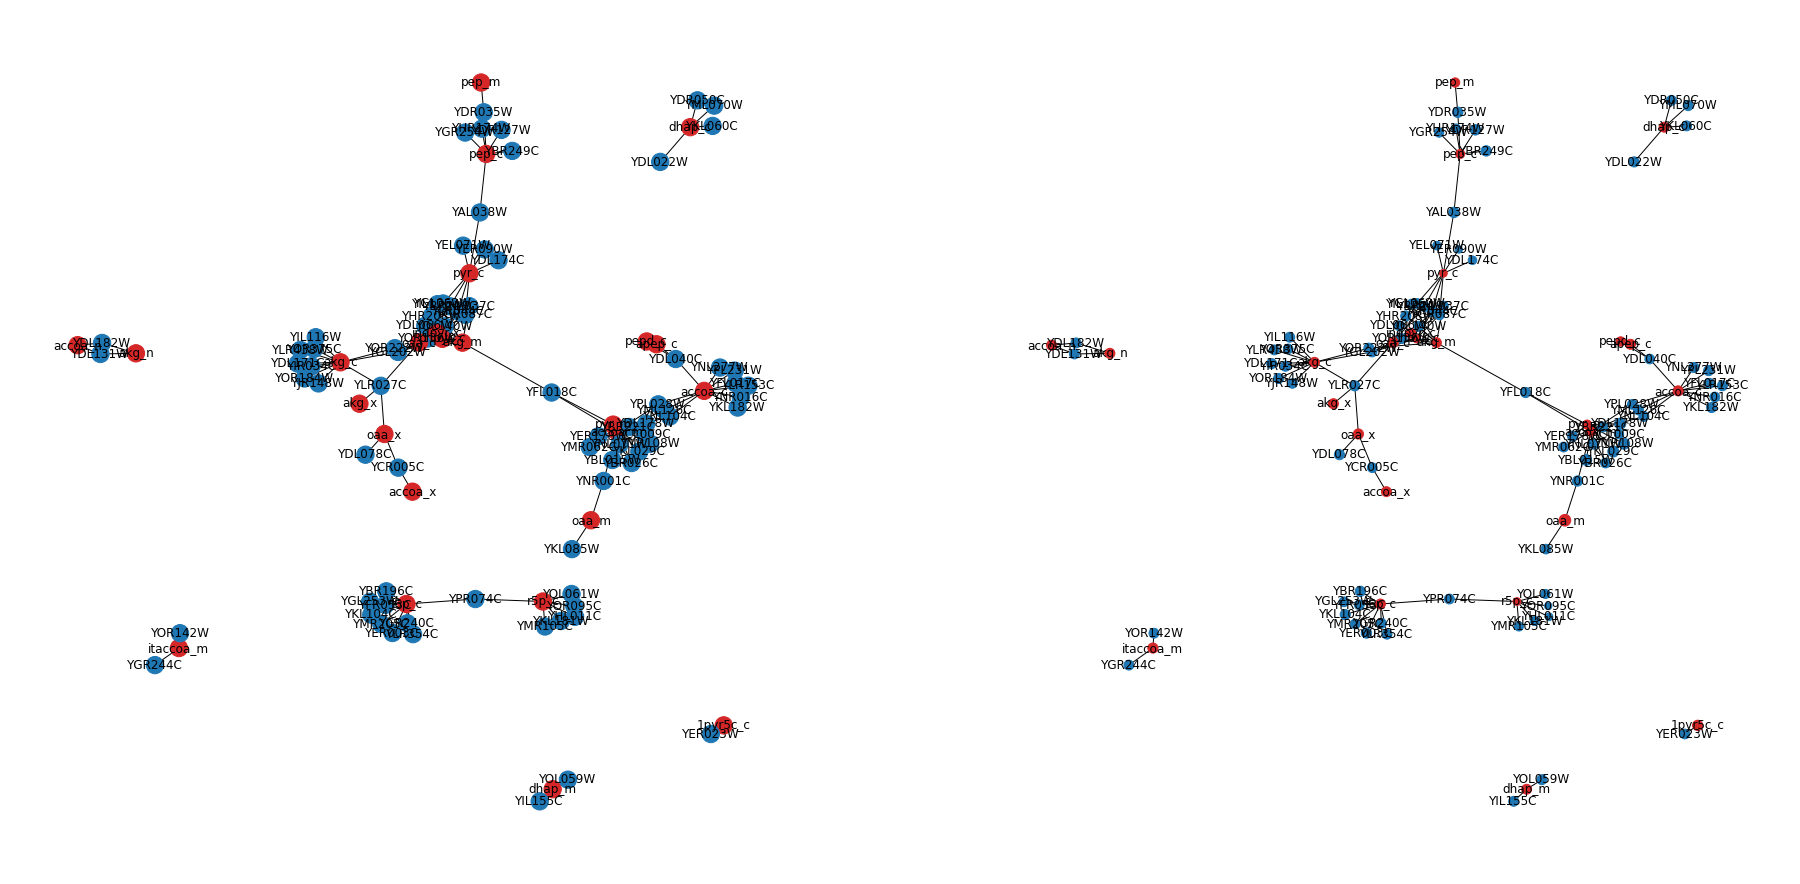

In [12]:
G = nx.from_edgelist(
    zip(edge_list_df['metabolite_id'], edge_list_df['enzyme'])
)

color_map = ["tab:blue" if node in ENZYMES else "tab:red" for node in G]
node_size = np.random.randint(10, size=len(G)) * 100


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16))

pos = nx.fruchterman_reingold_layout(G)
nx.draw(
    G,
    pos = pos,
    with_labels = True,
    node_color = color_map,
    # node_size = knockout_effect.loc['WT'].values,
    ax=ax1
)

nx.draw(
    G,
    pos = pos,
    with_labels = True,
    node_color = color_map,
    node_size = (knockout_effect.loc['YAL017W'].values / knockout_effect.loc['WT'].values) * 100,
    ax=ax2
)

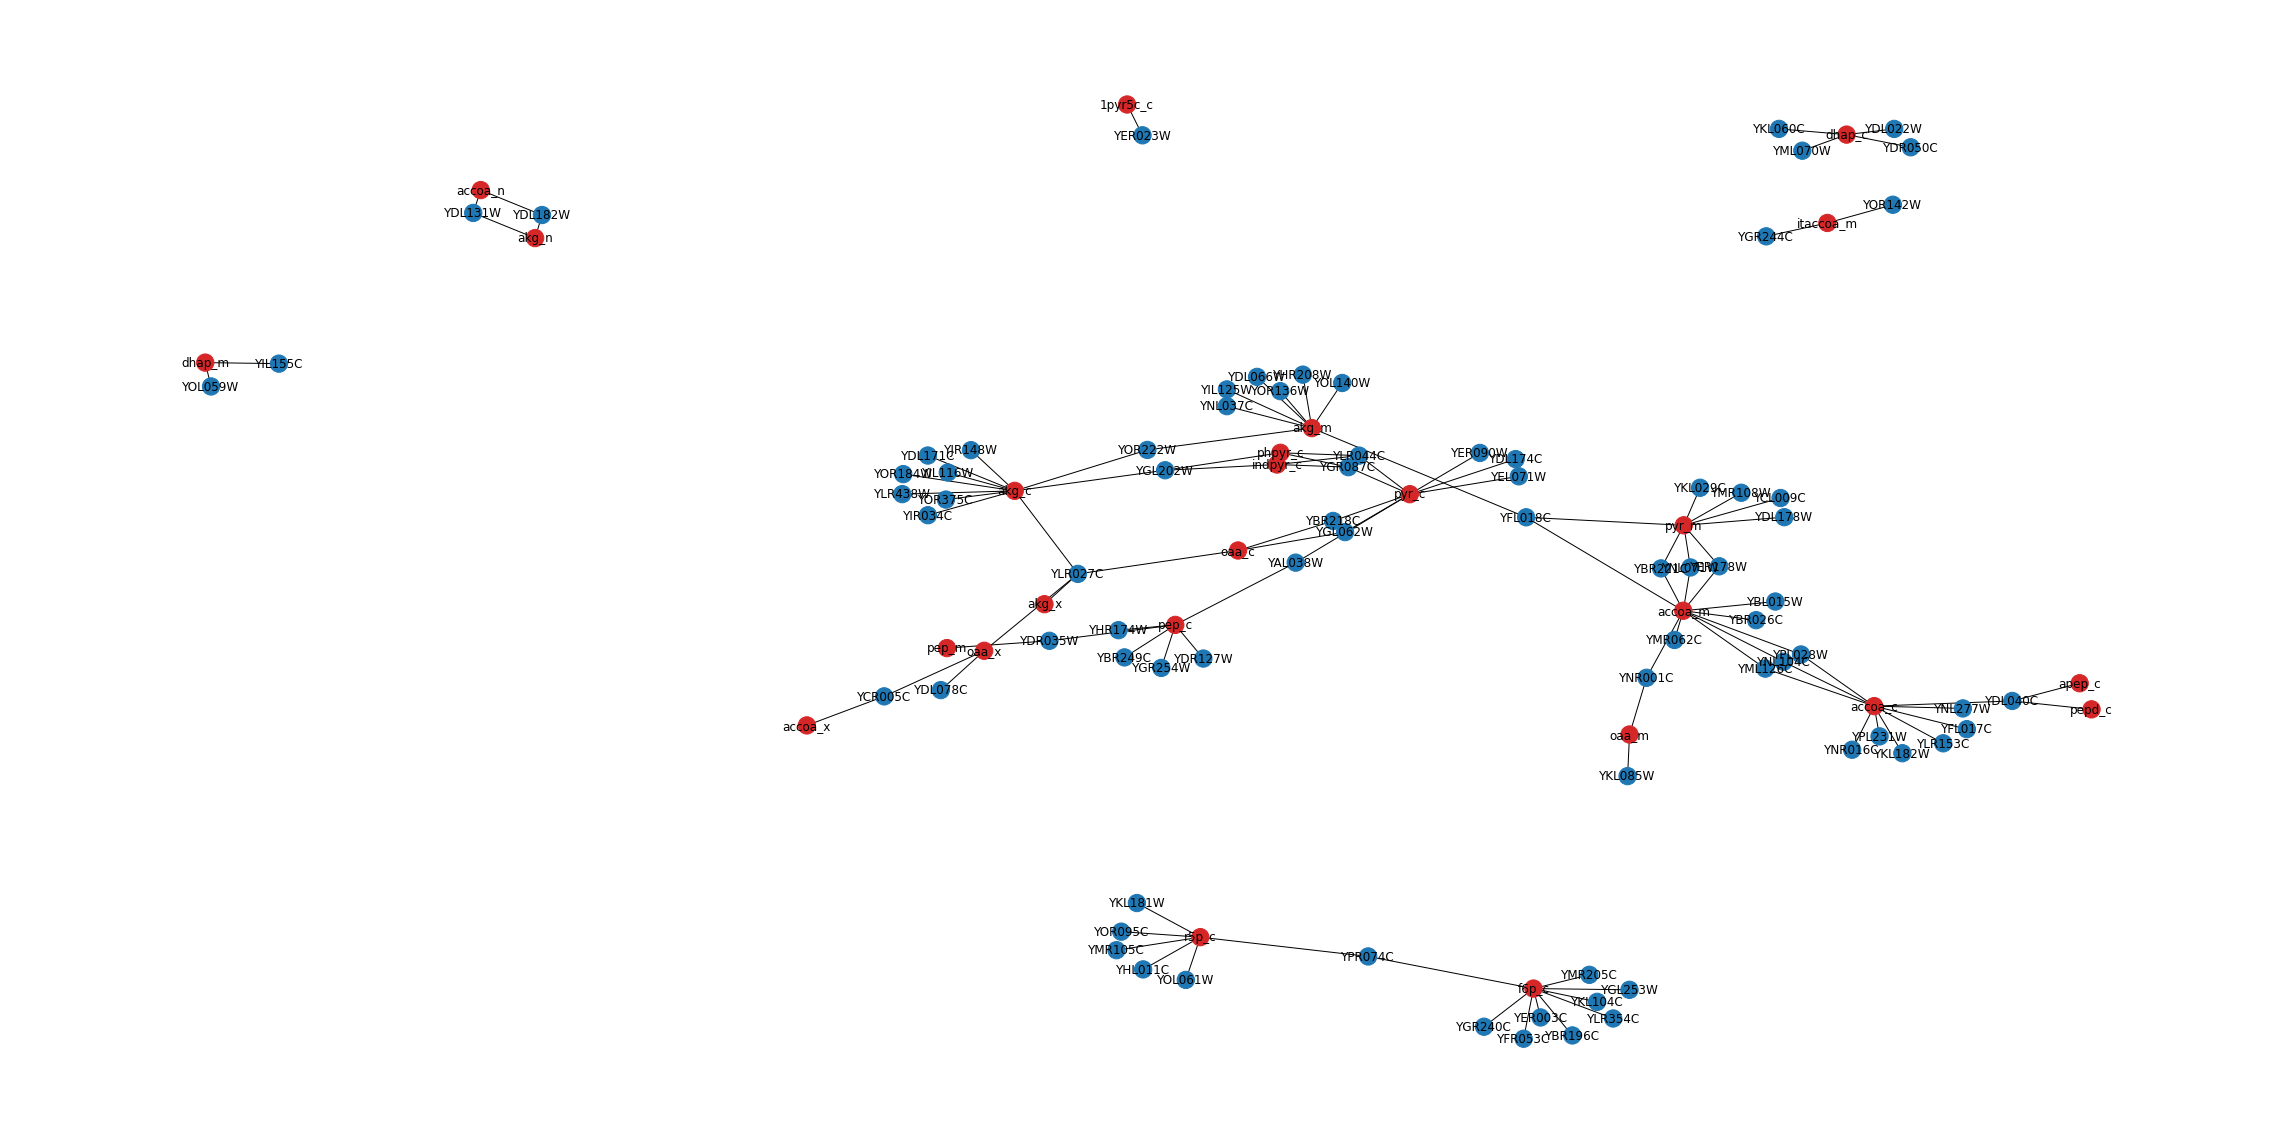

In [21]:
G = nx.from_edgelist(
    zip(edge_list_df['metabolite_id'], edge_list_df['enzyme'])
)

color_map = ["tab:blue" if node in ENZYMES else "tab:red" for node in G]
node_size = np.random.randint(10, size=len(G)) * 100


fig, ax = plt.subplots(1, 1, figsize=(32, 16))

pos = nx.fruchterman_reingold_layout(G, k = 0.1)
nx.draw(
    G,
    pos = pos,
    with_labels = True,
    node_color = color_map,
    # node_size = knockout_effect.loc['WT'].values,
    ax=ax
)
plt.tight_layout()
plt.savefig("./images/explorative/wt_graph_metabolite_enzyme_interaction.png")
plt.savefig("./images/explorative/wt_graph_metabolite_enzyme_interaction.svg")

In [ ]:
G = nx.from_edgelist(
    zip(edge_list_df['metabolite_id'], edge_list_df['enzyme'])
)
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

df = pd.DataFrame({
    "degree": np.unique(degree_sequence, return_counts=True)[0],
    "total": np.unique(degree_sequence, return_counts=True)[1],
    "metabolite": np.unique(degree_sequence, return_counts=True)[1],
    "enzyme": np.unique(degree_sequence, return_counts=True)[1],
})

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [27]:
np.unique(degree_sequence, return_counts=True)[1]

array([63, 21,  9,  2,  2,  3,  1,  2,  1])

In [53]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_absolute_error

from src.utils.utils import get_generator, get_project_root
from src.utils.test_result_store import TestResultStore

from src.pipeline.config import DataLoaderConfig, TaskLoaderConfig
from src.pipeline.taskloader import TaskLoader, TaskFrame
from src.pipeline.dataloader import DataLoader

from src.orchestrator.trainer import Trainer

from src.settings.tier import Tier
from src.settings.strategy import Strategy

from scipy.stats import pearsonr

In [54]:

DataLoader.DATA_FOLDER = f'{get_project_root()}/data/training/'

tier = Tier.TIER0
strategy = Strategy.ALL

dl_config = DataLoaderConfig(
    additional_filters=["is_precursor", ],
    additional_transforms=["log_fold_change_protein", ]
)

tl_config = TaskLoaderConfig(
    data_throttle=1,
    tier=tier,
)

dl = DataLoader()
dl.prepare_dataloader(dl_config)

tl = TaskLoader()
tl.prepare_taskloader(tl_config)

gen = get_generator(dl, tl, strategy, tier)
tf = next(gen)
trainer = Trainer()

x_scaler = StandardScaler()
y_scaler = MinMaxScaler()

df_x = tf.x.reset_index(level="metabolite_id", drop=True).drop_duplicates()
df_y: pd.DataFrame = tf.y.to_frame().reset_index().pivot_table(values='metabolite_concentration', index='KO_ORF', columns='metabolite_id').loc[df_x.index]

scaled_x = x_scaler.fit_transform(df_x)
scaled_y = y_scaler.fit_transform(df_y)

matching_precursor_metabolite = [
    (metabolite_id, df_y.loc[:, metabolite_id].values) 
    for cobra_metabolite_id in edge_list_df['metabolite_id'].unique()
    if (metabolite_id := list(filter(lambda p: p in cobra_metabolite_id, PRECURSOR_METABOLITES))[0])
]

cobra_df_y = pd.DataFrame.from_records(matching_precursor_metabolite).T
cobra_df_y = cobra_df_y.explode(cobra_df_y.columns.to_list()) \
    .drop(0) \
    .set_index(df_y.index) \
    .set_axis(edge_list_df['metabolite_id'].unique(), axis=1) \
    .fillna(0)
cobra_df_y

graph_fc_df = pd.concat([
    pd.DataFrame(scaled_x, index=df_x.index, columns=df_x.columns).loc[:, edge_list_df['enzyme'].unique()],
    cobra_df_y,
], axis=1).fillna(0)
graph_fc_df

,YER023W,YDL171C,YGL202W,YIL116W,YIR034C,YJR148W,YLR027C,YLR438W,YOR184W,YOR222W,...,oaa_c,oaa_m,oaa_x,pep_c,pep_m,pepd_c,pyr_c,pyr_m,phpyr_c,r5p_c
KO_ORF,,,,,,,,,,,,,,,,,,,,,
YIL042C,-0.969029,-2.304559,-0.737037,0.339897,0.960885,0.654887,0.349338,0.099800,0.468463,-0.701322,...,-0.245894,-0.245894,-0.245894,-0.978687,-0.978687,-0.978687,-0.634178,-0.634178,-0.634178,0.678711
YJL165C,1.164430,-0.072016,-1.225448,0.586780,-1.237295,0.049398,0.428505,1.181753,0.338875,0.755451,...,0.000000,0.000000,0.000000,1.043652,1.043652,1.043652,1.092846,1.092846,1.092846,0.985114
YGL021W,1.305231,-0.793295,-1.130607,-1.348830,-1.614843,-0.714943,-0.001702,1.139297,0.170540,0.669257,...,0.000000,0.000000,0.000000,0.813646,0.813646,0.813646,0.709497,0.709497,0.709497,0.553354
YBR097W,0.165782,2.260744,0.671154,-0.543079,-0.025932,-1.459547,1.032065,0.544460,0.059210,0.279459,...,0.607377,0.607377,0.607377,-0.900175,-0.900175,-0.900175,-0.422620,-0.422620,-0.422620,-0.085501
YLR248W,1.021343,0.283321,0.012454,0.072029,-1.076696,-0.117186,-0.278663,0.673055,0.292707,0.561919,...,0.000000,0.000000,0.000000,0.663582,0.663582,0.663582,0.464969,0.464969,0.464969,0.437722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YNL298W,0.270512,-0.350702,0.097735,-1.945682,0.803792,0.812723,0.023365,-0.261414,0.262624,-1.330398,...,-0.053197,-0.053197,-0.053197,-0.910425,-0.910425,-0.910425,-0.508526,-0.508526,-0.508526,-0.417934
YJL057C,-1.121898,0.304880,-0.151327,-0.307458,0.471590,-1.548688,-1.648500,-0.058072,-1.028107,0.409978,...,0.000000,0.000000,0.000000,0.947120,0.947120,0.947120,0.424999,0.424999,0.424999,0.756066
YMR104C,0.908561,-1.629202,-1.052250,0.098705,0.162208,0.089617,0.031696,0.616125,0.270433,0.204984,...,0.000000,0.000000,0.000000,1.028383,1.028383,1.028383,1.096708,1.096708,1.096708,1.174909


In [77]:
split_kwargs = dict(
    stratify='metabolite_id',
    shuffle=True
)
X_train, X_test, y_train, y_test = trainer.do_train_test_split(tf, Strategy.ALL, **split_kwargs)


,KO_ORF,metabolite_id,YAL003W,YAL005C,YAL007C,YAL012W,YAL035W,YAL038W,YAL042W,YAL044C,...,YPR129W,YPR133C,YPR145W,YPR160W,YPR163C,YPR165W,YPR181C,YPR183W,YPR187W,YPR191W
611,YPL026C,pyr,-0.002198,-0.03795,-0.060558,0.007294,-0.186281,-0.04846,0.041155,0.038323,...,-0.03513,-0.059447,0.027028,-0.192624,0.006705,-0.010857,-0.086625,0.003636,-0.081267,-0.0921
613,YDR283C,pyr,0.017555,-0.076065,-0.061209,0.011286,0.018549,0.008711,-0.009352,0.026502,...,-0.069326,-0.324817,0.070247,-0.172386,0.001622,-0.069682,0.021129,0.013553,0.07633,-0.089072
639,YHL007C,pyr,-0.036282,-0.067467,0.030711,0.035135,-0.227369,-0.014634,-0.027973,0.064704,...,0.042287,-0.328926,0.078334,-0.291876,-0.046843,-0.053745,0.015801,0.028987,0.095051,-0.063228
612,YNL298W,pyr,-0.034556,-0.017811,0.029812,0.002889,-0.169501,-0.026267,-0.11835,0.064426,...,0.039726,-0.404891,0.041641,-0.161638,-0.098259,-0.040284,0.020678,0.05174,0.042288,-0.049028
567,YOL128C,pyr,0.055436,-0.027535,-0.136392,0.013986,-0.434241,-0.086303,-0.049045,0.024197,...,-0.012445,-0.216417,0.052807,-0.143745,0.016833,-0.006105,-0.159053,-0.004698,-0.056376,-0.084139
603,YPL150W,pyr,0.02928,-0.11011,-0.032344,0.023786,-0.544263,-0.013546,-0.253585,0.050707,...,-0.070824,-0.171389,0.10241,-0.192994,-0.011574,-0.058441,-0.013849,0.02404,0.058205,-0.139852
574,YMR139W,pyr,-0.038668,-0.027626,-0.031949,-0.022701,0.108425,0.030214,-0.06414,0.019103,...,-0.028875,-0.008913,0.030769,-0.096747,-0.040455,-0.021898,0.018779,0.014819,0.03633,-0.059691
578,YCR073C,pyr,0.030797,-0.008337,-0.223871,0.021099,-0.148526,-0.086989,-0.032189,0.029805,...,0.004238,0.084762,0.046955,-0.146245,-0.009173,0.00412,-0.048864,0.031702,0.184596,-0.016929
629,YDR523C,pyr,-0.050774,-0.048127,-0.184115,-0.046729,-0.083506,-0.011357,0.055108,0.027775,...,0.048828,0.015828,0.052518,-0.127645,-0.039383,0.005059,-0.011231,0.039287,0.014224,-0.095563
557,YNL154C,pyr,0.075793,-0.011741,0.031072,0.057574,-0.380762,-0.130955,0.048888,0.045953,...,0.041743,0.048928,0.085453,-0.093144,-0.007244,-0.021457,-0.022538,0.004453,0.111962,-0.029838


In [84]:
h = np.array(X_test['KO_ORF'].unique())
k = np.array(X_test[X_test['metabolite_id'] == 'pyr']['KO_ORF'].unique())

np.argwhere(np.isin(h, k)).flatten().shape

(29,)

# Modeling

In [56]:

import torch
from torch.nn import Linear, BatchNorm1d, ModuleList
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch_geometric.nn import GAT, GCNConv

import mlflow.pytorch

from tqdm import tqdm

mlflow.set_tracking_uri("http://localhost:5000")

In [98]:
G = nx.from_edgelist(
    zip(edge_list_df['metabolite_id'], edge_list_df['enzyme'])
)

def data_augmentation_is_metabolite(node_name: str):
    return node_name not in ENZYMES

def data_augmentation_is_enzyme(node_name: str):
    return node_name in ENZYMES

def data_augmentation_train_mask(node_name: str, target_metabolite_id: str):
    return node_name not in ENZYMES and get_matching_precursor_metabolite(node_name) != target_metabolite_id

def data_augmentation_test_mask(node_name: str, target_metabolite_id: str):
    return node_name not in ENZYMES and get_matching_precursor_metabolite(node_name) == target_metabolite_id

def data_augmentation_get_knockout_idx(knockout: str):
    return graph_fc_df.index.get_loc(knockout)

def data_augmentation_get_knockout_label(knockout_id: int):
    return graph_fc_df.iloc[[knockout_id]].index

def get_samples(target_metabolite_id: str):
    samples: List[Data] = []

    for idx, row_series in graph_fc_df.iterrows():
        # print(row_series.to_dict())
        attributes = {
            key: { 
                "fc": value, 
                "is_metabolite": data_augmentation_is_metabolite(key),
                "is_enzyme": data_augmentation_is_enzyme(key),
                "train_mask": data_augmentation_train_mask(key, target_metabolite_id),
                "test_mask": data_augmentation_test_mask(key, target_metabolite_id),
                "knockout_label_id": data_augmentation_get_knockout_idx(idx),
            } 
            for key, value in row_series.to_dict().items()
        }
        group_node_attr = list(attributes[list(attributes.keys())[0]].keys())
        
        nx.set_node_attributes(G, attributes)
        data: Data = from_networkx(G, group_node_attrs=group_node_attr)
        data.y = data.x[:, 0]
        data.train_mask = data.x[:, 3]
        data.test_mask = data.x[:, 4]
        data.knockout_id = data.x[:, 5]
        data.x = data.x[:, :3]
        samples.append(data)
        
    print(samples[0])
    return samples

get_samples("pyr")

Data(edge_index=[2, 216], x=[104, 3], y=[104], train_mask=[104], test_mask=[104], knockout_id=[104])


[Data(edge_index=[2, 216], x=[104, 3], y=[104], train_mask=[104], test_mask=[104], knockout_id=[104]),
 Data(edge_index=[2, 216], x=[104, 3], y=[104], train_mask=[104], test_mask=[104], knockout_id=[104]),
 Data(edge_index=[2, 216], x=[104, 3], y=[104], train_mask=[104], test_mask=[104], knockout_id=[104]),
 Data(edge_index=[2, 216], x=[104, 3], y=[104], train_mask=[104], test_mask=[104], knockout_id=[104]),
 Data(edge_index=[2, 216], x=[104, 3], y=[104], train_mask=[104], test_mask=[104], knockout_id=[104]),
 Data(edge_index=[2, 216], x=[104, 3], y=[104], train_mask=[104], test_mask=[104], knockout_id=[104]),
 Data(edge_index=[2, 216], x=[104, 3], y=[104], train_mask=[104], test_mask=[104], knockout_id=[104]),
 Data(edge_index=[2, 216], x=[104, 3], y=[104], train_mask=[104], test_mask=[104], knockout_id=[104]),
 Data(edge_index=[2, 216], x=[104, 3], y=[104], train_mask=[104], test_mask=[104], knockout_id=[104]),
 Data(edge_index=[2, 216], x=[104, 3], y=[104], train_mask=[104], test_ma

In [58]:
torch.manual_seed(42)

class GCNModel(torch.nn.Module):
    def __init__(self, feature_size, model_config) -> None:
        super(GCNModel, self).__init__()
        embedding_size = model_config["model_embedding_size"]
        n_heads = model_config["model_attention_heads"]
        self.n_layers = model_config["model_layers"]
        dropout_rate = model_config["model_dropout_rate"]
        top_k_ratio = model_config["model_top_k_ratio"]
        self.top_k_every_n = model_config["model_top_k_every_n"]
        dense_neurons = model_config["model_dense_neurons"]
        edge_dim = model_config["model_edge_dim"]
        
        self.conv_layers = ModuleList([])
        self.transf_layers = ModuleList([])
        self.pooling_layers = ModuleList([])
        self.bn_layers = ModuleList([])
        
        self.conv1 = GCNConv(
            feature_size, embedding_size
        )
        # self.transf1 = Linear(embedding_size, embedding_size)
        self.bn1 = BatchNorm1d(embedding_size)
        
        self.conv2 = GCNConv(
            embedding_size, embedding_size
        )
        
        self.linear1 = Linear(embedding_size, 64)
        self.linear2 = Linear(64, 1)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = F.dropout(x, p=0.8, training=self.training)
        
        x = self.bn1(x)
        
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        
        x = self.linear1(x)
        x = torch.relu(x)
        
        x = self.linear2(x)
        return x 

In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_one_epoch(epoch, model, train_loader, optimizer, loss_fn):
    # Enumerate over the data
    running_loss = 0.0
    step = 0
    for _, batch in enumerate(tqdm(train_loader)):
        # Use GPU
        batch.to(device)
        # Reset gradients
        optimizer.zero_grad() 
        # Passing the node features and the connection info
        pred = model.forward(
            batch.x.float(), 
            batch.edge_index, 
            # batch.edge_attr.float(),
            # batch.batch
        ) 
        # Calculating the loss and gradients
        train_mask = batch.train_mask
        loss = loss_fn(torch.squeeze(pred), batch.y.float())
        loss = train_mask.float() * loss
        loss = loss.mean()
        
        loss.backward()  
        optimizer.step()  
        # Update tracking
        running_loss += loss.item()
        step += 1
    return running_loss/step

In [102]:
model_config = {
    "model_embedding_size": 32,
    "model_attention_heads": 3,
    "model_layers": 1,
    "model_dropout_rate": 0.5,
    "model_top_k_ratio": 0.5,
    "model_top_k_every_n": 2,
    "model_dense_neurons": 128,
    "model_edge_dim": 1,
}


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def log_metrics(all_preds, all_ground_truth, all_knockout_ids, epoch, type: str):
    mae = mean_absolute_error(all_ground_truth, all_preds)
    r2 = pearsonr(all_preds, all_ground_truth)[0]
    all_knockout_ids = [data_augmentation_get_knockout_label(knockout_id) for knockout_id in all_knockout_ids]
    
    k = np.array(X_test[X_test['metabolite_id'] == 'pyr']['KO_ORF'].unique())
    mask_idx = np.argwhere(np.isin(all_knockout_ids, k)).flatten()
    masked_mae = mean_absolute_error(all_ground_truth[mask_idx], all_preds[mask_idx])
    masked_r2 = pearsonr(all_preds[mask_idx], all_ground_truth[mask_idx])[0]
    
    print(f"{mae=}")
    print(f"{r2=}")
    mlflow.log_metric(key="Mean absolute error", value=float(mae), step=epoch)
    mlflow.log_metric(key="R2 score", value=float(r2), step=epoch)
    mlflow.log_metric(key="Masked Mean absolute error", value=float(masked_mae), step=epoch)
    mlflow.log_metric(key="Masked R2 score", value=float(masked_r2), step=epoch)
    

def test(epoch, model, test_loader, loss_fn):
    all_preds_raw = []
    all_labels = []
    all_knockout_ids = []
    running_loss = 0.0
    step = 0
    for batch in test_loader:
        batch.to(device)  
        pred = model(
            batch.x.float(), 
            batch.edge_index, 
        ) 
        
        test_mask = batch.test_mask
        loss = loss_fn(torch.squeeze(pred), batch.y.float())
        loss = test_mask.float() * loss
        loss = loss.mean()

         # Update tracking
        running_loss += loss.item()
        step += 1
        all_preds_raw.append(pred.cpu().detach().numpy())
        all_labels.append(batch.y.cpu().detach().numpy())
        all_knockout_ids.append(batch.knockout_id.cpu().detach().numpy())
    
    all_preds_raw = np.concatenate(all_preds_raw).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    all_knockout_ids = np.concatenate(all_knockout_ids).ravel()
    log_metrics(all_preds_raw, all_labels, all_knockout_ids, epoch, "test")
    return running_loss/step

def run_one_training(metabolite_id):
    samples = get_samples(metabolite_id)
    with mlflow.start_run(run_name=f"model_{metabolite_id}", nested=True) as run:
        # Preparing training
        train_loader = GeoDataLoader(samples, batch_size=4)
        test_loader = GeoDataLoader(samples, batch_size=4)
        
        # Loading the model
        print("Loading model...")
        model = GCNModel(feature_size=3, model_config=model_config)
        model = model.to(device)
        print(f"Number of parameters: {count_parameters(model)}")

        # < 1 increases precision, > 1 recall
        loss_fn = torch.nn.MSELoss(reduction='none')
        optimizer = torch.optim.SGD(model.parameters(), 
                                    lr=0.01,
                                    momentum=0.8,
                                    weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
        
        # Start training
        best_loss = 1000
        early_stopping_counter = 0
        for epoch in range(1000): 
            if early_stopping_counter <= 10: # = x * 5 
                # Training
                model.train()
                loss = train_one_epoch(epoch, model, train_loader, optimizer, loss_fn)
                print(f"Epoch {epoch} | Train Loss {loss}")
                mlflow.log_metric(key="Train loss", value=float(loss), step=epoch)

                # Testing
                model.eval()
                if epoch % 5 == 0:
                    loss = test(epoch, model, test_loader, loss_fn)
                    print(f"Epoch {epoch} | Test Loss {loss}")
                    mlflow.log_metric(key="Test loss", value=float(loss), step=epoch)
                    
                    # Update best loss
                    if float(loss) < best_loss:
                        best_loss = loss
                        # Save the currently best model 
                        # mlflow.pytorch.log_model(model, "model", signature=SIGNATURE)
                        early_stopping_counter = 0
                    else:
                        early_stopping_counter += 1

                scheduler.step()
            else:
                print("Early stopping due to no improvement.")
                return [best_loss]
    print(f"Finishing training with best test loss: {best_loss}")
    return [best_loss]

In [104]:
with mlflow.start_run() as run:
    for metabolite_id in PRECURSOR_METABOLITES:
        run_one_training(metabolite_id)

Data(edge_index=[2, 216], x=[104, 3], y=[104], train_mask=[104], test_mask=[104], knockout_id=[104])
Loading model...
Number of parameters: 3425


100%|██████████| 24/24 [00:00<00:00, 139.87it/s]

Epoch 0 | Train Loss 0.06869998248293996


mae=0.6886936
r2=0.5310080647936744
Epoch 0 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 38.11it/s]


Epoch 1 | Train Loss 0.06831356665740411


100%|██████████| 24/24 [00:00<00:00, 142.63it/s]


Epoch 2 | Train Loss 0.06593141875540216


100%|██████████| 24/24 [00:00<00:00, 60.63it/s]


Epoch 3 | Train Loss 0.06365974790727098


100%|██████████| 24/24 [00:00<00:00, 101.53it/s]


Epoch 4 | Train Loss 0.06434427822629611


100%|██████████| 24/24 [00:00<00:00, 121.30it/s]


Epoch 5 | Train Loss 0.06348014436662197
mae=0.67362285
r2=0.6705965902444452
Epoch 5 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 140.47it/s]


Epoch 6 | Train Loss 0.06372966167206566


100%|██████████| 24/24 [00:00<00:00, 98.05it/s] 


Epoch 7 | Train Loss 0.06154417603587111


100%|██████████| 24/24 [00:00<00:00, 71.57it/s]


Epoch 8 | Train Loss 0.06094480895747741


100%|██████████| 24/24 [00:00<00:00, 160.82it/s]


Epoch 9 | Train Loss 0.06236734318857392


100%|██████████| 24/24 [00:00<00:00, 109.83it/s]


Epoch 10 | Train Loss 0.06127217349906763
mae=0.6654339
r2=0.6949910495938113
Epoch 10 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 149.76it/s]


Epoch 11 | Train Loss 0.06070833932608366


100%|██████████| 24/24 [00:00<00:00, 167.82it/s]


Epoch 12 | Train Loss 0.059796755822996296


100%|██████████| 24/24 [00:00<00:00, 152.78it/s]


Epoch 13 | Train Loss 0.06113563136508068


100%|██████████| 24/24 [00:00<00:00, 168.60it/s]


Epoch 14 | Train Loss 0.06063163451229533


100%|██████████| 24/24 [00:00<00:00, 146.30it/s]


Epoch 15 | Train Loss 0.06190701170514027
mae=0.6628116
r2=0.6924543800734454
Epoch 15 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 99.65it/s]


Epoch 16 | Train Loss 0.06134660495445132


100%|██████████| 24/24 [00:00<00:00, 145.81it/s]


Epoch 17 | Train Loss 0.06071997666731477


100%|██████████| 24/24 [00:00<00:00, 148.58it/s]


Epoch 18 | Train Loss 0.06076320121064782


100%|██████████| 24/24 [00:00<00:00, 161.25it/s]


Epoch 19 | Train Loss 0.059995255743463836


100%|██████████| 24/24 [00:00<00:00, 163.48it/s]


Epoch 20 | Train Loss 0.06030488479882479
mae=0.65973294
r2=0.6962784747005045
Epoch 20 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 138.50it/s]


Epoch 21 | Train Loss 0.05965076433494687


100%|██████████| 24/24 [00:00<00:00, 147.20it/s]


Epoch 22 | Train Loss 0.05972981685772538


100%|██████████| 24/24 [00:00<00:00, 151.72it/s]


Epoch 23 | Train Loss 0.05940417045106491


100%|██████████| 24/24 [00:00<00:00, 130.56it/s]


Epoch 24 | Train Loss 0.058822608242432274


100%|██████████| 24/24 [00:00<00:00, 96.58it/s]


Epoch 25 | Train Loss 0.06003031445046266
mae=0.6593214
r2=0.6936576177954755
Epoch 25 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 120.74it/s]


Epoch 26 | Train Loss 0.059450802548478045


100%|██████████| 24/24 [00:00<00:00, 111.56it/s]


Epoch 27 | Train Loss 0.06065497314557433


100%|██████████| 24/24 [00:00<00:00, 117.28it/s]


Epoch 28 | Train Loss 0.05912092855821053


100%|██████████| 24/24 [00:00<00:00, 127.45it/s]


Epoch 29 | Train Loss 0.06010936899110675


100%|██████████| 24/24 [00:00<00:00, 139.01it/s]


Epoch 30 | Train Loss 0.05895900586619973
mae=0.65732294
r2=0.6985001600726576
Epoch 30 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 148.47it/s]


Epoch 31 | Train Loss 0.059254336481293045


100%|██████████| 24/24 [00:00<00:00, 96.07it/s] 


Epoch 32 | Train Loss 0.05992085036511222


100%|██████████| 24/24 [00:00<00:00, 126.31it/s]


Epoch 33 | Train Loss 0.059423728535572685


100%|██████████| 24/24 [00:00<00:00, 93.26it/s]


Epoch 34 | Train Loss 0.06006050016731024


100%|██████████| 24/24 [00:00<00:00, 92.50it/s]


Epoch 35 | Train Loss 0.05988130656381448
mae=0.6583731
r2=0.6934616139063855
Epoch 35 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 83.25it/s]


Epoch 36 | Train Loss 0.05937731374676029


100%|██████████| 24/24 [00:00<00:00, 144.44it/s]


Epoch 37 | Train Loss 0.05924120731651783


100%|██████████| 24/24 [00:00<00:00, 73.21it/s]


Epoch 38 | Train Loss 0.06044918578118086


100%|██████████| 24/24 [00:00<00:00, 89.59it/s]


Epoch 39 | Train Loss 0.05987542945270737


100%|██████████| 24/24 [00:00<00:00, 128.75it/s]


Epoch 40 | Train Loss 0.05868503047774235
mae=0.65524656
r2=0.6993312306448398
Epoch 40 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 66.72it/s]


Epoch 41 | Train Loss 0.06013490849485


100%|██████████| 24/24 [00:00<00:00, 143.85it/s]


Epoch 42 | Train Loss 0.060505991180737816


100%|██████████| 24/24 [00:00<00:00, 151.21it/s]


Epoch 43 | Train Loss 0.05961998691782355


100%|██████████| 24/24 [00:00<00:00, 159.86it/s]


Epoch 44 | Train Loss 0.05895354055489103


100%|██████████| 24/24 [00:00<00:00, 151.58it/s]


Epoch 45 | Train Loss 0.05987849831581116
mae=0.6567455
r2=0.6970711020692927
Epoch 45 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 131.29it/s]


Epoch 46 | Train Loss 0.05849728686735034


100%|██████████| 24/24 [00:00<00:00, 128.80it/s]


Epoch 47 | Train Loss 0.05961875539893905


100%|██████████| 24/24 [00:00<00:00, 115.08it/s]


Epoch 48 | Train Loss 0.058609946010013424


100%|██████████| 24/24 [00:00<00:00, 155.42it/s]


Epoch 49 | Train Loss 0.06029222998768091


100%|██████████| 24/24 [00:00<00:00, 164.13it/s]


Epoch 50 | Train Loss 0.05969061562791467
mae=0.65590686
r2=0.6994763140668839
Epoch 50 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 86.56it/s]


Epoch 51 | Train Loss 0.05801466309155027


100%|██████████| 24/24 [00:00<00:00, 124.84it/s]


Epoch 52 | Train Loss 0.059090106282383204


100%|██████████| 24/24 [00:00<00:00, 155.75it/s]


Epoch 53 | Train Loss 0.06053705948094527


100%|██████████| 24/24 [00:00<00:00, 142.55it/s]


Epoch 54 | Train Loss 0.05989126783485214


100%|██████████| 24/24 [00:00<00:00, 155.54it/s]


Epoch 55 | Train Loss 0.0599146030532817
mae=0.65633076
r2=0.6957614709224184
Epoch 55 | Test Loss 0.0
Early stopping due to no improvement.
Data(edge_index=[2, 216], x=[104, 3], y=[104], train_mask=[104], test_mask=[104], knockout_id=[104])
Loading model...
Number of parameters: 3425


100%|██████████| 24/24 [00:00<00:00, 132.93it/s]


Epoch 0 | Train Loss 0.07459962383533518
mae=0.69678587
r2=0.5349161575806178
Epoch 0 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 74.16it/s]


Epoch 1 | Train Loss 0.06742800554881494


100%|██████████| 24/24 [00:00<00:00, 151.84it/s]


Epoch 2 | Train Loss 0.06444790819659829


100%|██████████| 24/24 [00:00<00:00, 75.08it/s] 


Epoch 3 | Train Loss 0.06363662503038843


100%|██████████| 24/24 [00:00<00:00, 80.25it/s]


Epoch 4 | Train Loss 0.06296502752229571


100%|██████████| 24/24 [00:00<00:00, 154.70it/s]


Epoch 5 | Train Loss 0.06075501830006639
mae=0.6722658
r2=0.6402758259477683
Epoch 5 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 163.82it/s]


Epoch 6 | Train Loss 0.06179883905375997


100%|██████████| 24/24 [00:00<00:00, 166.30it/s]


Epoch 7 | Train Loss 0.06009407931317886


100%|██████████| 24/24 [00:00<00:00, 157.23it/s]


Epoch 8 | Train Loss 0.06094655844693383


100%|██████████| 24/24 [00:00<00:00, 149.02it/s]


Epoch 9 | Train Loss 0.060789730244626604


100%|██████████| 24/24 [00:00<00:00, 130.95it/s]


Epoch 10 | Train Loss 0.0597703168168664
mae=0.66202235
r2=0.6595186331020642
Epoch 10 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 152.34it/s]

Epoch 11 | Train Loss 0.059736698400229216



100%|██████████| 24/24 [00:00<00:00, 170.63it/s]


Epoch 12 | Train Loss 0.058820085134357214


100%|██████████| 24/24 [00:00<00:00, 162.29it/s]


Epoch 13 | Train Loss 0.06017652293667197


100%|██████████| 24/24 [00:00<00:00, 75.62it/s]


Epoch 14 | Train Loss 0.06002499566723903


100%|██████████| 24/24 [00:00<00:00, 75.88it/s]


Epoch 15 | Train Loss 0.05967088943968216
mae=0.6581695
r2=0.6628188386556624
Epoch 15 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 153.80it/s]

Epoch 16 | Train Loss 0.058795224875211716



100%|██████████| 24/24 [00:00<00:00, 165.51it/s]


Epoch 17 | Train Loss 0.058004667361577354


100%|██████████| 24/24 [00:00<00:00, 163.36it/s]


Epoch 18 | Train Loss 0.05950566132863363


100%|██████████| 24/24 [00:00<00:00, 161.39it/s]


Epoch 19 | Train Loss 0.05894810613244772


100%|██████████| 24/24 [00:00<00:00, 132.77it/s]


Epoch 20 | Train Loss 0.059204246227939926
mae=0.6542254
r2=0.6750587583730372
Epoch 20 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 155.83it/s]

Epoch 21 | Train Loss 0.05834042731051644



100%|██████████| 24/24 [00:00<00:00, 82.58it/s] 


Epoch 22 | Train Loss 0.05955834065874418


100%|██████████| 24/24 [00:00<00:00, 151.95it/s]


Epoch 23 | Train Loss 0.058781662645439305


100%|██████████| 24/24 [00:00<00:00, 143.70it/s]


Epoch 24 | Train Loss 0.05849031017472347


100%|██████████| 24/24 [00:00<00:00, 157.80it/s]


Epoch 25 | Train Loss 0.05873362394049764
mae=0.65344375
r2=0.6789377016752818
Epoch 25 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 54.18it/s]


Epoch 26 | Train Loss 0.059387859888374805


100%|██████████| 24/24 [00:00<00:00, 154.36it/s]


Epoch 27 | Train Loss 0.059315326468398176


100%|██████████| 24/24 [00:00<00:00, 151.17it/s]


Epoch 28 | Train Loss 0.05879994838808974


100%|██████████| 24/24 [00:00<00:00, 159.94it/s]


Epoch 29 | Train Loss 0.058503471625347934


100%|██████████| 24/24 [00:00<00:00, 130.66it/s]


Epoch 30 | Train Loss 0.058879574916015066
mae=0.6530937
r2=0.6795368894570302
Epoch 30 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 47.63it/s]


Epoch 31 | Train Loss 0.05852510733529925


100%|██████████| 24/24 [00:00<00:00, 125.51it/s]


Epoch 32 | Train Loss 0.05794931917140881


100%|██████████| 24/24 [00:00<00:00, 166.38it/s]


Epoch 33 | Train Loss 0.05840230748678247


100%|██████████| 24/24 [00:00<00:00, 154.82it/s]


Epoch 34 | Train Loss 0.05861594978099068


100%|██████████| 24/24 [00:00<00:00, 146.17it/s]


Epoch 35 | Train Loss 0.05942967114970088
mae=0.6528289
r2=0.681886723245443
Epoch 35 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 158.09it/s]


Epoch 36 | Train Loss 0.05999915829549233


100%|██████████| 24/24 [00:00<00:00, 146.79it/s]


Epoch 37 | Train Loss 0.05788671147699157


100%|██████████| 24/24 [00:00<00:00, 149.80it/s]


Epoch 38 | Train Loss 0.05800582002848387


100%|██████████| 24/24 [00:00<00:00, 149.08it/s]


Epoch 39 | Train Loss 0.059113790901998677


100%|██████████| 24/24 [00:00<00:00, 108.94it/s]


Epoch 40 | Train Loss 0.059210465755313635
mae=0.6516647
r2=0.6777727834322389
Epoch 40 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 133.49it/s]


Epoch 41 | Train Loss 0.05820254608988762


100%|██████████| 24/24 [00:00<00:00, 154.10it/s]


Epoch 42 | Train Loss 0.05832868395373225


100%|██████████| 24/24 [00:00<00:00, 153.55it/s]


Epoch 43 | Train Loss 0.05903469600404302


100%|██████████| 24/24 [00:00<00:00, 156.37it/s]


Epoch 44 | Train Loss 0.058609973484029375


100%|██████████| 24/24 [00:00<00:00, 138.35it/s]


Epoch 45 | Train Loss 0.05853847460821271
mae=0.65317035
r2=0.6807630993377851
Epoch 45 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 87.32it/s]


Epoch 46 | Train Loss 0.05924957059323788


100%|██████████| 24/24 [00:00<00:00, 152.37it/s]


Epoch 47 | Train Loss 0.05855530702198545


100%|██████████| 24/24 [00:00<00:00, 118.50it/s]


Epoch 48 | Train Loss 0.057775115904708706


100%|██████████| 24/24 [00:00<00:00, 157.91it/s]


Epoch 49 | Train Loss 0.05760949927692612


100%|██████████| 24/24 [00:00<00:00, 165.47it/s]


Epoch 50 | Train Loss 0.0580713142020007
mae=0.65192664
r2=0.6773817286952813
Epoch 50 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 100.05it/s]


Epoch 51 | Train Loss 0.058737741938481726


100%|██████████| 24/24 [00:00<00:00, 160.46it/s]


Epoch 52 | Train Loss 0.0570828279790779


100%|██████████| 24/24 [00:00<00:00, 137.19it/s]


Epoch 53 | Train Loss 0.05784769635647535


100%|██████████| 24/24 [00:00<00:00, 152.25it/s]


Epoch 54 | Train Loss 0.05847245454788208


100%|██████████| 24/24 [00:00<00:00, 158.92it/s]


Epoch 55 | Train Loss 0.057943167009701334
mae=0.6519792
r2=0.6818041092741511
Epoch 55 | Test Loss 0.0
Early stopping due to no improvement.
Data(edge_index=[2, 216], x=[104, 3], y=[104], train_mask=[104], test_mask=[104], knockout_id=[104])
Loading model...
Number of parameters: 3425


100%|██████████| 24/24 [00:00<00:00, 146.85it/s]

Epoch 0 | Train Loss 0.08699701493605971


mae=0.69274795
r2=0.06299523664271667
Epoch 0 | Test Loss 0.006130347290309146


100%|██████████| 24/24 [00:00<00:00, 60.73it/s] 


Epoch 1 | Train Loss 0.06359591319536169


100%|██████████| 24/24 [00:00<00:00, 87.73it/s]


Epoch 2 | Train Loss 0.06244812440127134


100%|██████████| 24/24 [00:00<00:00, 150.51it/s]


Epoch 3 | Train Loss 0.06120941927656531


100%|██████████| 24/24 [00:00<00:00, 136.07it/s]


Epoch 4 | Train Loss 0.061160961321244635


100%|██████████| 24/24 [00:00<00:00, 158.67it/s]


Epoch 5 | Train Loss 0.05970876027519504
mae=0.6683399
r2=0.6959199656831645
Epoch 5 | Test Loss 0.005007644698101406


100%|██████████| 24/24 [00:00<00:00, 154.40it/s]

Epoch 6 | Train Loss 0.05852313991636038



100%|██████████| 24/24 [00:00<00:00, 153.17it/s]


Epoch 7 | Train Loss 0.05684728097791473


100%|██████████| 24/24 [00:00<00:00, 123.65it/s]


Epoch 8 | Train Loss 0.05776733051364621


100%|██████████| 24/24 [00:00<00:00, 125.65it/s]


Epoch 9 | Train Loss 0.05713832207644979


100%|██████████| 24/24 [00:00<00:00, 147.48it/s]


Epoch 10 | Train Loss 0.05836480747287472
mae=0.65952194
r2=0.7047732203894195
Epoch 10 | Test Loss 0.0048201896230845405


100%|██████████| 24/24 [00:00<00:00, 87.61it/s]


Epoch 11 | Train Loss 0.05762845588227113


100%|██████████| 24/24 [00:00<00:00, 145.33it/s]


Epoch 12 | Train Loss 0.0579644573541979


100%|██████████| 24/24 [00:00<00:00, 76.95it/s]


Epoch 13 | Train Loss 0.056457945300887026


100%|██████████| 24/24 [00:00<00:00, 152.45it/s]


Epoch 14 | Train Loss 0.05655417094628016


100%|██████████| 24/24 [00:00<00:00, 153.12it/s]


Epoch 15 | Train Loss 0.05667509604245424
mae=0.6532262
r2=0.7102728514012076
Epoch 15 | Test Loss 0.004730632281280123


100%|██████████| 24/24 [00:00<00:00, 151.53it/s]

Epoch 16 | Train Loss 0.056961462988207735



100%|██████████| 24/24 [00:00<00:00, 153.85it/s]


Epoch 17 | Train Loss 0.056125206096718706


100%|██████████| 24/24 [00:00<00:00, 137.17it/s]


Epoch 18 | Train Loss 0.05694004769126574


100%|██████████| 24/24 [00:00<00:00, 52.25it/s]


Epoch 19 | Train Loss 0.056887949196000896


100%|██████████| 24/24 [00:00<00:00, 147.60it/s]


Epoch 20 | Train Loss 0.05591500333199898
mae=0.6529213
r2=0.7079460098597201
Epoch 20 | Test Loss 0.004746893934983139


100%|██████████| 24/24 [00:00<00:00, 141.79it/s]


Epoch 21 | Train Loss 0.05568797327578068


100%|██████████| 24/24 [00:00<00:00, 152.50it/s]


Epoch 22 | Train Loss 0.05596609630932411


100%|██████████| 24/24 [00:00<00:00, 154.51it/s]


Epoch 23 | Train Loss 0.05619611653188864


100%|██████████| 24/24 [00:00<00:00, 155.71it/s]


Epoch 24 | Train Loss 0.056182089261710644


100%|██████████| 24/24 [00:00<00:00, 151.79it/s]


Epoch 25 | Train Loss 0.05620618878553311
mae=0.65168715
r2=0.7150868756357137
Epoch 25 | Test Loss 0.004702770888494949


100%|██████████| 24/24 [00:00<00:00, 147.70it/s]


Epoch 26 | Train Loss 0.056218843907117844


100%|██████████| 24/24 [00:00<00:00, 160.98it/s]


Epoch 27 | Train Loss 0.05550590576604009


100%|██████████| 24/24 [00:00<00:00, 162.70it/s]


Epoch 28 | Train Loss 0.05687261434892813


100%|██████████| 24/24 [00:00<00:00, 151.97it/s]


Epoch 29 | Train Loss 0.056387743446975946


100%|██████████| 24/24 [00:00<00:00, 156.74it/s]


Epoch 30 | Train Loss 0.05600007902830839
mae=0.6495071
r2=0.7154148928377061
Epoch 30 | Test Loss 0.004662502920837142


100%|██████████| 24/24 [00:00<00:00, 151.37it/s]

Epoch 31 | Train Loss 0.05603262704486648



100%|██████████| 24/24 [00:00<00:00, 160.73it/s]


Epoch 32 | Train Loss 0.05516451193640629


100%|██████████| 24/24 [00:00<00:00, 152.21it/s]


Epoch 33 | Train Loss 0.05562021303921938


100%|██████████| 24/24 [00:00<00:00, 78.28it/s]


Epoch 34 | Train Loss 0.055054557509720325


100%|██████████| 24/24 [00:00<00:00, 103.72it/s]


Epoch 35 | Train Loss 0.05596569009746114
mae=0.6501744
r2=0.7132516327140265
Epoch 35 | Test Loss 0.004650714569531071


100%|██████████| 24/24 [00:00<00:00, 107.13it/s]


Epoch 36 | Train Loss 0.055167756509035826


100%|██████████| 24/24 [00:00<00:00, 155.67it/s]


Epoch 37 | Train Loss 0.05521488174175223


100%|██████████| 24/24 [00:00<00:00, 147.76it/s]


Epoch 38 | Train Loss 0.05723710606495539


100%|██████████| 24/24 [00:00<00:00, 158.69it/s]


Epoch 39 | Train Loss 0.05509794239575664


100%|██████████| 24/24 [00:00<00:00, 155.97it/s]


Epoch 40 | Train Loss 0.056395985962202154
mae=0.6505204
r2=0.7100745965359504
Epoch 40 | Test Loss 0.004703741928096861


100%|██████████| 24/24 [00:00<00:00, 139.07it/s]


Epoch 41 | Train Loss 0.05707515714069208


100%|██████████| 24/24 [00:00<00:00, 142.67it/s]


Epoch 42 | Train Loss 0.0559731504569451


100%|██████████| 24/24 [00:00<00:00, 142.43it/s]


Epoch 43 | Train Loss 0.05543257653092345


100%|██████████| 24/24 [00:00<00:00, 151.53it/s]


Epoch 44 | Train Loss 0.05578350958724817


100%|██████████| 24/24 [00:00<00:00, 154.07it/s]


Epoch 45 | Train Loss 0.05700041245048245
mae=0.6499241
r2=0.7130146132085907
Epoch 45 | Test Loss 0.004707100510131568


100%|██████████| 24/24 [00:00<00:00, 147.56it/s]


Epoch 46 | Train Loss 0.05542497197166085


100%|██████████| 24/24 [00:00<00:00, 147.72it/s]


Epoch 47 | Train Loss 0.05492805953448018


100%|██████████| 24/24 [00:00<00:00, 140.00it/s]


Epoch 48 | Train Loss 0.05578305401528875


100%|██████████| 24/24 [00:00<00:00, 142.18it/s]


Epoch 49 | Train Loss 0.056875389690200485


100%|██████████| 24/24 [00:00<00:00, 157.38it/s]


Epoch 50 | Train Loss 0.055939994752407074
mae=0.6500859
r2=0.713064667635278
Epoch 50 | Test Loss 0.004660045063549963


100%|██████████| 24/24 [00:00<00:00, 130.05it/s]


Epoch 51 | Train Loss 0.05549877214555939


100%|██████████| 24/24 [00:00<00:00, 138.57it/s]


Epoch 52 | Train Loss 0.056061687568823494


100%|██████████| 24/24 [00:00<00:00, 146.09it/s]


Epoch 53 | Train Loss 0.054689721980442606


100%|██████████| 24/24 [00:00<00:00, 114.80it/s]


Epoch 54 | Train Loss 0.05512862931936979


100%|██████████| 24/24 [00:00<00:00, 92.09it/s]


Epoch 55 | Train Loss 0.056467464193701744
mae=0.65045875
r2=0.714119362915098
Epoch 55 | Test Loss 0.004632283191313036


100%|██████████| 24/24 [00:00<00:00, 144.78it/s]


Epoch 56 | Train Loss 0.05500826612114906


100%|██████████| 24/24 [00:00<00:00, 143.91it/s]


Epoch 57 | Train Loss 0.05621555478622516


100%|██████████| 24/24 [00:00<00:00, 94.69it/s] 


Epoch 58 | Train Loss 0.05525733778874079


100%|██████████| 24/24 [00:00<00:00, 139.10it/s]


Epoch 59 | Train Loss 0.0561353350058198


100%|██████████| 24/24 [00:00<00:00, 154.86it/s]


Epoch 60 | Train Loss 0.05641605658456683
mae=0.65034467
r2=0.7130832021036868
Epoch 60 | Test Loss 0.004650356218917295


100%|██████████| 24/24 [00:00<00:00, 142.09it/s]


Epoch 61 | Train Loss 0.05540981966381272


100%|██████████| 24/24 [00:00<00:00, 131.37it/s]


Epoch 62 | Train Loss 0.0562893731209139


100%|██████████| 24/24 [00:00<00:00, 152.07it/s]


Epoch 63 | Train Loss 0.05525808253635963


100%|██████████| 24/24 [00:00<00:00, 148.11it/s]


Epoch 64 | Train Loss 0.05471851614614328


100%|██████████| 24/24 [00:00<00:00, 152.38it/s]


Epoch 65 | Train Loss 0.05605805106461048
mae=0.6493192
r2=0.7163561344544225
Epoch 65 | Test Loss 0.004688606970982316


100%|██████████| 24/24 [00:00<00:00, 144.56it/s]


Epoch 66 | Train Loss 0.05617968582858642


100%|██████████| 24/24 [00:00<00:00, 140.77it/s]


Epoch 67 | Train Loss 0.055917758494615555


100%|██████████| 24/24 [00:00<00:00, 151.39it/s]


Epoch 68 | Train Loss 0.05583118523160616


100%|██████████| 24/24 [00:00<00:00, 144.14it/s]


Epoch 69 | Train Loss 0.055330871138721704


100%|██████████| 24/24 [00:00<00:00, 146.93it/s]


Epoch 70 | Train Loss 0.05574788417046269
mae=0.6486341
r2=0.7136120219766845
Epoch 70 | Test Loss 0.004702828727507343


100%|██████████| 24/24 [00:00<00:00, 143.35it/s]


Epoch 71 | Train Loss 0.05554237977291147


100%|██████████| 24/24 [00:00<00:00, 149.59it/s]


Epoch 72 | Train Loss 0.05698753520846367


100%|██████████| 24/24 [00:00<00:00, 150.15it/s]


Epoch 73 | Train Loss 0.05624606041237712


100%|██████████| 24/24 [00:00<00:00, 148.72it/s]


Epoch 74 | Train Loss 0.056483535251269736


100%|██████████| 24/24 [00:00<00:00, 147.86it/s]


Epoch 75 | Train Loss 0.0556346126832068
mae=0.6498581
r2=0.7142916536111029
Epoch 75 | Test Loss 0.004696157964644954


100%|██████████| 24/24 [00:00<00:00, 134.78it/s]


Epoch 76 | Train Loss 0.055644769221544266


100%|██████████| 24/24 [00:00<00:00, 149.06it/s]


Epoch 77 | Train Loss 0.05583779436225692


100%|██████████| 24/24 [00:00<00:00, 148.66it/s]


Epoch 78 | Train Loss 0.057769466346750654


100%|██████████| 24/24 [00:00<00:00, 142.63it/s]


Epoch 79 | Train Loss 0.05562399451931318


100%|██████████| 24/24 [00:00<00:00, 131.91it/s]


Epoch 80 | Train Loss 0.056701320223510265
mae=0.64872414
r2=0.7163271747063977
Epoch 80 | Test Loss 0.0046466860512737185


100%|██████████| 24/24 [00:00<00:00, 64.91it/s]


Epoch 81 | Train Loss 0.05513620221366485


100%|██████████| 24/24 [00:00<00:00, 70.40it/s]


Epoch 82 | Train Loss 0.05596468939135472


100%|██████████| 24/24 [00:00<00:00, 140.61it/s]


Epoch 83 | Train Loss 0.05499417924632629


100%|██████████| 24/24 [00:00<00:00, 148.48it/s]


Epoch 84 | Train Loss 0.053213732627530895


100%|██████████| 24/24 [00:00<00:00, 155.05it/s]


Epoch 85 | Train Loss 0.05580129583055774
mae=0.6499929
r2=0.7171515327526405
Epoch 85 | Test Loss 0.004641352531810601


100%|██████████| 24/24 [00:00<00:00, 128.79it/s]


Epoch 86 | Train Loss 0.05634356724719206


100%|██████████| 24/24 [00:00<00:00, 138.90it/s]


Epoch 87 | Train Loss 0.05607100762426853


100%|██████████| 24/24 [00:00<00:00, 86.99it/s]


Epoch 88 | Train Loss 0.05531943511838714


100%|██████████| 24/24 [00:00<00:00, 148.88it/s]


Epoch 89 | Train Loss 0.05426790735994776


100%|██████████| 24/24 [00:00<00:00, 144.49it/s]


Epoch 90 | Train Loss 0.05648188013583422
mae=0.6488333
r2=0.7139764113061806
Epoch 90 | Test Loss 0.004656972814700566


100%|██████████| 24/24 [00:00<00:00, 88.55it/s]


Epoch 91 | Train Loss 0.055120924642930426


100%|██████████| 24/24 [00:00<00:00, 148.28it/s]


Epoch 92 | Train Loss 0.05560817747997741


100%|██████████| 24/24 [00:00<00:00, 151.46it/s]


Epoch 93 | Train Loss 0.05563307926058769


100%|██████████| 24/24 [00:00<00:00, 84.47it/s]


Epoch 94 | Train Loss 0.05559378210455179


100%|██████████| 24/24 [00:00<00:00, 134.77it/s]


Epoch 95 | Train Loss 0.05651888344436884
mae=0.65021837
r2=0.7167694037879663
Epoch 95 | Test Loss 0.004638297177734785


100%|██████████| 24/24 [00:00<00:00, 139.96it/s]


Epoch 96 | Train Loss 0.056347096183647714


100%|██████████| 24/24 [00:00<00:00, 151.18it/s]


Epoch 97 | Train Loss 0.056712651159614325


100%|██████████| 24/24 [00:00<00:00, 152.07it/s]


Epoch 98 | Train Loss 0.05548717609296242


100%|██████████| 24/24 [00:00<00:00, 148.68it/s]


Epoch 99 | Train Loss 0.05537439572314421


100%|██████████| 24/24 [00:00<00:00, 137.54it/s]


Epoch 100 | Train Loss 0.05610247002914548
mae=0.64901906
r2=0.7177938252570797
Epoch 100 | Test Loss 0.004651578948444997


100%|██████████| 24/24 [00:00<00:00, 149.30it/s]


Epoch 101 | Train Loss 0.05505860519285003


100%|██████████| 24/24 [00:00<00:00, 132.34it/s]


Epoch 102 | Train Loss 0.05575764660413066


100%|██████████| 24/24 [00:00<00:00, 150.79it/s]


Epoch 103 | Train Loss 0.05647168277452389


100%|██████████| 24/24 [00:00<00:00, 149.06it/s]


Epoch 104 | Train Loss 0.05554046916464964


100%|██████████| 24/24 [00:00<00:00, 145.57it/s]


Epoch 105 | Train Loss 0.05449234259625276
mae=0.6493335
r2=0.7121271853386031
Epoch 105 | Test Loss 0.004669516585029972


100%|██████████| 24/24 [00:00<00:00, 134.69it/s]


Epoch 106 | Train Loss 0.05617390852421522


100%|██████████| 24/24 [00:00<00:00, 132.81it/s]


Epoch 107 | Train Loss 0.05497439485043287


100%|██████████| 24/24 [00:00<00:00, 145.32it/s]


Epoch 108 | Train Loss 0.054575196700170636


100%|██████████| 24/24 [00:00<00:00, 150.54it/s]


Epoch 109 | Train Loss 0.05635418758417169


100%|██████████| 24/24 [00:00<00:00, 139.81it/s]


Epoch 110 | Train Loss 0.056492086965590715
mae=0.6487724
r2=0.7152644785558477
Epoch 110 | Test Loss 0.004671005216854003
Early stopping due to no improvement.
Data(edge_index=[2, 216], x=[104, 3], y=[104], train_mask=[104], test_mask=[104], knockout_id=[104])
Loading model...
Number of parameters: 3425


100%|██████████| 24/24 [00:00<00:00, 136.46it/s]


Epoch 0 | Train Loss 0.06336349109187722
mae=0.70672977
r2=-0.6911287579799787
Epoch 0 | Test Loss 0.011060428281780332


100%|██████████| 24/24 [00:00<00:00, 139.14it/s]


Epoch 1 | Train Loss 0.06002107666184505


100%|██████████| 24/24 [00:00<00:00, 111.46it/s]


Epoch 2 | Train Loss 0.057200959573189415


100%|██████████| 24/24 [00:00<00:00, 133.06it/s]


Epoch 3 | Train Loss 0.057209841907024384


100%|██████████| 24/24 [00:00<00:00, 135.25it/s]


Epoch 4 | Train Loss 0.056321580428630114


100%|██████████| 24/24 [00:00<00:00, 135.74it/s]


Epoch 5 | Train Loss 0.0558264646679163
mae=0.6794288
r2=0.6950357782532958
Epoch 5 | Test Loss 0.009834568093841275


100%|██████████| 24/24 [00:00<00:00, 136.13it/s]


Epoch 6 | Train Loss 0.0545841654141744


100%|██████████| 24/24 [00:00<00:00, 92.12it/s]


Epoch 7 | Train Loss 0.054726936078319945


100%|██████████| 24/24 [00:00<00:00, 125.89it/s]


Epoch 8 | Train Loss 0.05369817620764176


100%|██████████| 24/24 [00:00<00:00, 58.37it/s]


Epoch 9 | Train Loss 0.05225110364456972


100%|██████████| 24/24 [00:00<00:00, 137.64it/s]


Epoch 10 | Train Loss 0.053454747423529625
mae=0.6683235
r2=0.7153464108691812
Epoch 10 | Test Loss 0.009595607853649804


100%|██████████| 24/24 [00:00<00:00, 142.42it/s]


Epoch 11 | Train Loss 0.05270919964338342


100%|██████████| 24/24 [00:00<00:00, 93.69it/s]


Epoch 12 | Train Loss 0.05260318579773108


100%|██████████| 24/24 [00:00<00:00, 143.21it/s]


Epoch 13 | Train Loss 0.05185298559566339


100%|██████████| 24/24 [00:00<00:00, 142.57it/s]


Epoch 14 | Train Loss 0.05126925876053671


100%|██████████| 24/24 [00:00<00:00, 113.69it/s]


Epoch 15 | Train Loss 0.052512901835143566
mae=0.66251117
r2=0.7234482590631249
Epoch 15 | Test Loss 0.009351221611723304


100%|██████████| 24/24 [00:00<00:00, 80.80it/s]


Epoch 16 | Train Loss 0.05260446714237332


100%|██████████| 24/24 [00:00<00:00, 137.88it/s]


Epoch 17 | Train Loss 0.0515755251981318


100%|██████████| 24/24 [00:00<00:00, 146.88it/s]


Epoch 18 | Train Loss 0.05205154434467355


100%|██████████| 24/24 [00:00<00:00, 142.64it/s]


Epoch 19 | Train Loss 0.05225879233330488


100%|██████████| 24/24 [00:00<00:00, 146.65it/s]


Epoch 20 | Train Loss 0.05185247849052151
mae=0.6606137
r2=0.7201567256962154
Epoch 20 | Test Loss 0.009324326529167593


100%|██████████| 24/24 [00:00<00:00, 85.25it/s]


Epoch 21 | Train Loss 0.05155663471668959


100%|██████████| 24/24 [00:00<00:00, 96.74it/s] 


Epoch 22 | Train Loss 0.05119110302378734


100%|██████████| 24/24 [00:00<00:00, 131.26it/s]


Epoch 23 | Train Loss 0.051375028056403


100%|██████████| 24/24 [00:00<00:00, 148.44it/s]


Epoch 24 | Train Loss 0.04998408483030895


100%|██████████| 24/24 [00:00<00:00, 155.35it/s]


Epoch 25 | Train Loss 0.051970669999718666
mae=0.6583426
r2=0.7245309181092254
Epoch 25 | Test Loss 0.009297261713072658


100%|██████████| 24/24 [00:00<00:00, 168.44it/s]


Epoch 26 | Train Loss 0.05082570458762348


100%|██████████| 24/24 [00:00<00:00, 153.21it/s]


Epoch 27 | Train Loss 0.05213138903491199


100%|██████████| 24/24 [00:00<00:00, 168.93it/s]


Epoch 28 | Train Loss 0.05125535248468319


100%|██████████| 24/24 [00:00<00:00, 171.12it/s]


Epoch 29 | Train Loss 0.050653767228747405


100%|██████████| 24/24 [00:00<00:00, 176.93it/s]


Epoch 30 | Train Loss 0.05171108967624605
mae=0.657505
r2=0.7236422052114612
Epoch 30 | Test Loss 0.00926220960294207


100%|██████████| 24/24 [00:00<00:00, 166.86it/s]


Epoch 31 | Train Loss 0.05215873887451986


100%|██████████| 24/24 [00:00<00:00, 159.35it/s]


Epoch 32 | Train Loss 0.051121996250003576


100%|██████████| 24/24 [00:00<00:00, 165.13it/s]


Epoch 33 | Train Loss 0.051918291642020144


100%|██████████| 24/24 [00:00<00:00, 170.81it/s]


Epoch 34 | Train Loss 0.050829213267813124


100%|██████████| 24/24 [00:00<00:00, 163.27it/s]


Epoch 35 | Train Loss 0.051134050358086824
mae=0.6556083
r2=0.7278307338989223
Epoch 35 | Test Loss 0.009218375625399252


100%|██████████| 24/24 [00:00<00:00, 113.76it/s]


Epoch 36 | Train Loss 0.05132186723252138


100%|██████████| 24/24 [00:00<00:00, 120.98it/s]


Epoch 37 | Train Loss 0.049559186678379774


100%|██████████| 24/24 [00:00<00:00, 113.32it/s]


Epoch 38 | Train Loss 0.048896185122430325


100%|██████████| 24/24 [00:00<00:00, 98.48it/s]


Epoch 39 | Train Loss 0.05193996895104647


100%|██████████| 24/24 [00:00<00:00, 149.87it/s]


Epoch 40 | Train Loss 0.05062166477243105
mae=0.6563878
r2=0.7267381967047087
Epoch 40 | Test Loss 0.009243352377476791


100%|██████████| 24/24 [00:00<00:00, 150.89it/s]

Epoch 41 | Train Loss 0.05088546872138977



100%|██████████| 24/24 [00:00<00:00, 167.86it/s]


Epoch 42 | Train Loss 0.05099519986348847


100%|██████████| 24/24 [00:00<00:00, 161.38it/s]


Epoch 43 | Train Loss 0.05121092894114554


100%|██████████| 24/24 [00:00<00:00, 86.82it/s]


Epoch 44 | Train Loss 0.05209864877785245


100%|██████████| 24/24 [00:00<00:00, 124.32it/s]


Epoch 45 | Train Loss 0.05103844994058212
mae=0.6549184
r2=0.7268532139904363
Epoch 45 | Test Loss 0.009223729255609214


100%|██████████| 24/24 [00:00<00:00, 161.98it/s]


Epoch 46 | Train Loss 0.05139593733474612


100%|██████████| 24/24 [00:00<00:00, 157.61it/s]


Epoch 47 | Train Loss 0.05046581321706375


100%|██████████| 24/24 [00:00<00:00, 162.41it/s]


Epoch 48 | Train Loss 0.049904442857950926


100%|██████████| 24/24 [00:00<00:00, 159.78it/s]


Epoch 49 | Train Loss 0.050210775497059025


100%|██████████| 24/24 [00:00<00:00, 168.69it/s]


Epoch 50 | Train Loss 0.050150124123319983
mae=0.65550035
r2=0.726447001439555
Epoch 50 | Test Loss 0.009284684162897369


100%|██████████| 24/24 [00:00<00:00, 168.09it/s]


Epoch 51 | Train Loss 0.05082640843465924


100%|██████████| 24/24 [00:00<00:00, 119.89it/s]


Epoch 52 | Train Loss 0.05098516819998622


100%|██████████| 24/24 [00:00<00:00, 98.79it/s]


Epoch 53 | Train Loss 0.05239703878760338


100%|██████████| 24/24 [00:00<00:00, 127.46it/s]


Epoch 54 | Train Loss 0.05149227986112237


100%|██████████| 24/24 [00:00<00:00, 150.92it/s]


Epoch 55 | Train Loss 0.04996506691289445
mae=0.65646803
r2=0.7240440435984722
Epoch 55 | Test Loss 0.009197967689639578


100%|██████████| 24/24 [00:00<00:00, 142.07it/s]


Epoch 56 | Train Loss 0.05092635859424869


100%|██████████| 24/24 [00:00<00:00, 119.83it/s]


Epoch 57 | Train Loss 0.05201739266825219


100%|██████████| 24/24 [00:00<00:00, 161.34it/s]


Epoch 58 | Train Loss 0.05129981157369912


100%|██████████| 24/24 [00:00<00:00, 172.44it/s]


Epoch 59 | Train Loss 0.05214808749345442


100%|██████████| 24/24 [00:00<00:00, 156.70it/s]


Epoch 60 | Train Loss 0.05138101917691529
mae=0.656188
r2=0.724928338573621
Epoch 60 | Test Loss 0.009232782409526408


100%|██████████| 24/24 [00:00<00:00, 87.04it/s]


Epoch 61 | Train Loss 0.05203834859033426


100%|██████████| 24/24 [00:00<00:00, 169.89it/s]


Epoch 62 | Train Loss 0.050579425413161516


100%|██████████| 24/24 [00:00<00:00, 154.36it/s]


Epoch 63 | Train Loss 0.05161133982862035


100%|██████████| 24/24 [00:00<00:00, 145.60it/s]


Epoch 64 | Train Loss 0.04974669838945071


100%|██████████| 24/24 [00:00<00:00, 103.53it/s]


Epoch 65 | Train Loss 0.05060893530026078
mae=0.65557325
r2=0.7250026112222748
Epoch 65 | Test Loss 0.009223865480938306


100%|██████████| 24/24 [00:00<00:00, 157.62it/s]


Epoch 66 | Train Loss 0.05098603914181391


100%|██████████| 24/24 [00:00<00:00, 173.30it/s]


Epoch 67 | Train Loss 0.05135590070858598


100%|██████████| 24/24 [00:00<00:00, 150.00it/s]


Epoch 68 | Train Loss 0.05108065033952395


100%|██████████| 24/24 [00:00<00:00, 173.33it/s]


Epoch 69 | Train Loss 0.05132950710443159


100%|██████████| 24/24 [00:00<00:00, 163.67it/s]


Epoch 70 | Train Loss 0.05151328002102673
mae=0.65600514
r2=0.7249041049198439
Epoch 70 | Test Loss 0.009235211706254631


100%|██████████| 24/24 [00:00<00:00, 159.71it/s]


Epoch 71 | Train Loss 0.051574785417566694


100%|██████████| 24/24 [00:00<00:00, 168.85it/s]


Epoch 72 | Train Loss 0.05106895688610772


100%|██████████| 24/24 [00:00<00:00, 90.12it/s]


Epoch 73 | Train Loss 0.05104152346029878


100%|██████████| 24/24 [00:00<00:00, 150.75it/s]


Epoch 74 | Train Loss 0.05072289674232403


100%|██████████| 24/24 [00:00<00:00, 167.92it/s]


Epoch 75 | Train Loss 0.050808137748390436
mae=0.65492386
r2=0.7269475729603793
Epoch 75 | Test Loss 0.009220861247740686


100%|██████████| 24/24 [00:00<00:00, 156.15it/s]


Epoch 76 | Train Loss 0.0506337684734414


100%|██████████| 24/24 [00:00<00:00, 161.92it/s]


Epoch 77 | Train Loss 0.0499943847147127


100%|██████████| 24/24 [00:00<00:00, 145.85it/s]


Epoch 78 | Train Loss 0.051223929428185024


100%|██████████| 24/24 [00:00<00:00, 158.40it/s]


Epoch 79 | Train Loss 0.05130031270285448


100%|██████████| 24/24 [00:00<00:00, 127.50it/s]


Epoch 80 | Train Loss 0.05119207827374339
mae=0.6545505
r2=0.7238632919966673
Epoch 80 | Test Loss 0.00918011466274038


100%|██████████| 24/24 [00:00<00:00, 162.60it/s]


Epoch 81 | Train Loss 0.05149260861799121


100%|██████████| 24/24 [00:00<00:00, 163.74it/s]


Epoch 82 | Train Loss 0.051543724024668336


100%|██████████| 24/24 [00:00<00:00, 127.83it/s]


Epoch 83 | Train Loss 0.04972183184387783


100%|██████████| 24/24 [00:00<00:00, 91.36it/s]


Epoch 84 | Train Loss 0.05095228816693028


100%|██████████| 24/24 [00:00<00:00, 165.60it/s]


Epoch 85 | Train Loss 0.051081124227494
mae=0.6562222
r2=0.722026643420873
Epoch 85 | Test Loss 0.009233984242503842


100%|██████████| 24/24 [00:00<00:00, 168.32it/s]


Epoch 86 | Train Loss 0.05051665458207329


100%|██████████| 24/24 [00:00<00:00, 169.78it/s]


Epoch 87 | Train Loss 0.050112537729243435


100%|██████████| 24/24 [00:00<00:00, 136.79it/s]


Epoch 88 | Train Loss 0.05136799975298345


100%|██████████| 24/24 [00:00<00:00, 169.21it/s]


Epoch 89 | Train Loss 0.05062793754041195


100%|██████████| 24/24 [00:00<00:00, 165.53it/s]


Epoch 90 | Train Loss 0.05029174863981704
mae=0.65533984
r2=0.7258792606127351
Epoch 90 | Test Loss 0.009205302436991284


100%|██████████| 24/24 [00:00<00:00, 165.03it/s]


Epoch 91 | Train Loss 0.051319547152767576


100%|██████████| 24/24 [00:00<00:00, 166.83it/s]


Epoch 92 | Train Loss 0.050332183949649334


100%|██████████| 24/24 [00:00<00:00, 151.78it/s]


Epoch 93 | Train Loss 0.05098650806273023


100%|██████████| 24/24 [00:00<00:00, 160.93it/s]


Epoch 94 | Train Loss 0.051357079607745014


100%|██████████| 24/24 [00:00<00:00, 167.11it/s]


Epoch 95 | Train Loss 0.051205352414399385
mae=0.65466475
r2=0.7251647654898018
Epoch 95 | Test Loss 0.009191440573583046


100%|██████████| 24/24 [00:00<00:00, 166.07it/s]


Epoch 96 | Train Loss 0.050097876926884055


100%|██████████| 24/24 [00:00<00:00, 146.54it/s]


Epoch 97 | Train Loss 0.05059587194894751


100%|██████████| 24/24 [00:00<00:00, 46.10it/s]


Epoch 98 | Train Loss 0.05173892768410345


100%|██████████| 24/24 [00:00<00:00, 87.94it/s]


Epoch 99 | Train Loss 0.05044067775209745


100%|██████████| 24/24 [00:00<00:00, 144.89it/s]


Epoch 100 | Train Loss 0.05029323285756012
mae=0.65643525
r2=0.7247071635067074
Epoch 100 | Test Loss 0.009213566915908208


100%|██████████| 24/24 [00:00<00:00, 163.67it/s]


Epoch 101 | Train Loss 0.0514800896247228


100%|██████████| 24/24 [00:00<00:00, 103.45it/s]


Epoch 102 | Train Loss 0.05024200639066597


100%|██████████| 24/24 [00:00<00:00, 127.52it/s]


Epoch 103 | Train Loss 0.04990162289080521


100%|██████████| 24/24 [00:00<00:00, 92.73it/s]


Epoch 104 | Train Loss 0.049956880897904433


100%|██████████| 24/24 [00:00<00:00, 96.47it/s]


Epoch 105 | Train Loss 0.05120954973002275
mae=0.6559634
r2=0.7236932639083329
Epoch 105 | Test Loss 0.009200425527524203


100%|██████████| 24/24 [00:00<00:00, 164.75it/s]


Epoch 106 | Train Loss 0.05114467814564705


100%|██████████| 24/24 [00:00<00:00, 161.42it/s]


Epoch 107 | Train Loss 0.05075300671160221


100%|██████████| 24/24 [00:00<00:00, 160.81it/s]


Epoch 108 | Train Loss 0.05067354976199567


100%|██████████| 24/24 [00:00<00:00, 140.13it/s]


Epoch 109 | Train Loss 0.05091345760350426


100%|██████████| 24/24 [00:00<00:00, 167.29it/s]


Epoch 110 | Train Loss 0.05090920665922264
mae=0.6546858
r2=0.7267019753285705
Epoch 110 | Test Loss 0.009153521968983114


100%|██████████| 24/24 [00:00<00:00, 163.44it/s]


Epoch 111 | Train Loss 0.05096930436169108


100%|██████████| 24/24 [00:00<00:00, 164.51it/s]


Epoch 112 | Train Loss 0.050481165992096066


100%|██████████| 24/24 [00:00<00:00, 154.87it/s]


Epoch 113 | Train Loss 0.051004702070107065


100%|██████████| 24/24 [00:00<00:00, 162.99it/s]


Epoch 114 | Train Loss 0.050689890049397945


100%|██████████| 24/24 [00:00<00:00, 102.04it/s]


Epoch 115 | Train Loss 0.05083766936634978
mae=0.6539611
r2=0.7258198606597581
Epoch 115 | Test Loss 0.009164029771151641


100%|██████████| 24/24 [00:00<00:00, 164.87it/s]


Epoch 116 | Train Loss 0.050774989649653435


100%|██████████| 24/24 [00:00<00:00, 156.35it/s]


Epoch 117 | Train Loss 0.05112231848761439


100%|██████████| 24/24 [00:00<00:00, 169.32it/s]


Epoch 118 | Train Loss 0.0517790379623572


100%|██████████| 24/24 [00:00<00:00, 161.72it/s]


Epoch 119 | Train Loss 0.05052672419697046


100%|██████████| 24/24 [00:00<00:00, 146.17it/s]


Epoch 120 | Train Loss 0.05206234993723532
mae=0.6563026
r2=0.7235656014583975
Epoch 120 | Test Loss 0.00927433823623384


100%|██████████| 24/24 [00:00<00:00, 139.93it/s]


Epoch 121 | Train Loss 0.05176999241424104


100%|██████████| 24/24 [00:00<00:00, 168.19it/s]


Epoch 122 | Train Loss 0.052514008323972426


100%|██████████| 24/24 [00:00<00:00, 153.81it/s]


Epoch 123 | Train Loss 0.050941784012441836


100%|██████████| 24/24 [00:00<00:00, 149.13it/s]


Epoch 124 | Train Loss 0.05040937103331089


100%|██████████| 24/24 [00:00<00:00, 146.68it/s]


Epoch 125 | Train Loss 0.049881646021579705
mae=0.6557903
r2=0.7266317744510934
Epoch 125 | Test Loss 0.009202774691705903


100%|██████████| 24/24 [00:00<00:00, 166.90it/s]


Epoch 126 | Train Loss 0.05134298047050834


100%|██████████| 24/24 [00:00<00:00, 146.11it/s]


Epoch 127 | Train Loss 0.053449231665581465


100%|██████████| 24/24 [00:00<00:00, 161.83it/s]


Epoch 128 | Train Loss 0.05129404839438697


100%|██████████| 24/24 [00:00<00:00, 148.29it/s]


Epoch 129 | Train Loss 0.051677859077850975


100%|██████████| 24/24 [00:00<00:00, 136.51it/s]


Epoch 130 | Train Loss 0.051424982181439795
mae=0.65521145
r2=0.7272877771692754
Epoch 130 | Test Loss 0.00916354893706739


100%|██████████| 24/24 [00:00<00:00, 137.09it/s]


Epoch 131 | Train Loss 0.051488961946840085


100%|██████████| 24/24 [00:00<00:00, 156.48it/s]


Epoch 132 | Train Loss 0.05275718138242761


100%|██████████| 24/24 [00:00<00:00, 140.56it/s]


Epoch 133 | Train Loss 0.050787491646284856


100%|██████████| 24/24 [00:00<00:00, 108.08it/s]


Epoch 134 | Train Loss 0.05184314694876472


100%|██████████| 24/24 [00:00<00:00, 125.66it/s]


Epoch 135 | Train Loss 0.05185902972395221
mae=0.6550535
r2=0.7266404446626977
Epoch 135 | Test Loss 0.009173229239725819


100%|██████████| 24/24 [00:00<00:00, 129.43it/s]


Epoch 136 | Train Loss 0.050352302845567465


100%|██████████| 24/24 [00:00<00:00, 81.18it/s]


Epoch 137 | Train Loss 0.05199162211890022


100%|██████████| 24/24 [00:00<00:00, 87.97it/s] 


Epoch 138 | Train Loss 0.04999965103343129


100%|██████████| 24/24 [00:00<00:00, 83.19it/s]


Epoch 139 | Train Loss 0.050603481863314904


100%|██████████| 24/24 [00:00<00:00, 130.80it/s]


Epoch 140 | Train Loss 0.05034177121706307
mae=0.6553677
r2=0.7264336525097185
Epoch 140 | Test Loss 0.009243155751998225


100%|██████████| 24/24 [00:00<00:00, 61.39it/s]


Epoch 141 | Train Loss 0.05110894679091871


100%|██████████| 24/24 [00:00<00:00, 49.53it/s]


Epoch 142 | Train Loss 0.050415334679807224


100%|██████████| 24/24 [00:00<00:00, 55.78it/s]


Epoch 143 | Train Loss 0.051016114031275116


100%|██████████| 24/24 [00:00<00:00, 50.70it/s]


Epoch 144 | Train Loss 0.05101281792546312


100%|██████████| 24/24 [00:00<00:00, 50.50it/s]


Epoch 145 | Train Loss 0.05134564358741045
mae=0.6564724
r2=0.7211611162676338
Epoch 145 | Test Loss 0.009273936952619502


100%|██████████| 24/24 [00:00<00:00, 72.16it/s]


Epoch 146 | Train Loss 0.05062386572050551


100%|██████████| 24/24 [00:00<00:00, 84.44it/s]


Epoch 147 | Train Loss 0.05130582209676504


100%|██████████| 24/24 [00:00<00:00, 91.95it/s]


Epoch 148 | Train Loss 0.0502752517350018


100%|██████████| 24/24 [00:00<00:00, 73.84it/s]


Epoch 149 | Train Loss 0.05011291359551251


100%|██████████| 24/24 [00:00<00:00, 74.98it/s]


Epoch 150 | Train Loss 0.0512078309742113
mae=0.6552165
r2=0.7274738753544545
Epoch 150 | Test Loss 0.00920670060440898


100%|██████████| 24/24 [00:00<00:00, 86.17it/s]


Epoch 151 | Train Loss 0.05151483075072368


100%|██████████| 24/24 [00:00<00:00, 53.31it/s]


Epoch 152 | Train Loss 0.051035644176105656


100%|██████████| 24/24 [00:00<00:00, 141.37it/s]


Epoch 153 | Train Loss 0.05090835349013408


100%|██████████| 24/24 [00:00<00:00, 156.44it/s]


Epoch 154 | Train Loss 0.04967219134171804


100%|██████████| 24/24 [00:00<00:00, 88.65it/s] 


Epoch 155 | Train Loss 0.05029349161001543
mae=0.6552231
r2=0.7251488830104164
Epoch 155 | Test Loss 0.009226417945077022


100%|██████████| 24/24 [00:00<00:00, 174.93it/s]


Epoch 156 | Train Loss 0.05066054523922503


100%|██████████| 24/24 [00:00<00:00, 72.89it/s]


Epoch 157 | Train Loss 0.051294405944645405


100%|██████████| 24/24 [00:00<00:00, 186.38it/s]


Epoch 158 | Train Loss 0.05070016463287175


100%|██████████| 24/24 [00:00<00:00, 173.68it/s]


Epoch 159 | Train Loss 0.051302066538482904


100%|██████████| 24/24 [00:00<00:00, 188.66it/s]


Epoch 160 | Train Loss 0.05154910497367382
mae=0.6549389
r2=0.7236284208904679
Epoch 160 | Test Loss 0.009257705610555908


100%|██████████| 24/24 [00:00<00:00, 171.86it/s]


Epoch 161 | Train Loss 0.05123377094666163


100%|██████████| 24/24 [00:00<00:00, 187.00it/s]


Epoch 162 | Train Loss 0.05106913469110926


100%|██████████| 24/24 [00:00<00:00, 94.54it/s] 


Epoch 163 | Train Loss 0.05272611160762608


100%|██████████| 24/24 [00:00<00:00, 153.42it/s]


Epoch 164 | Train Loss 0.050508657547955714


100%|██████████| 24/24 [00:00<00:00, 171.79it/s]


Epoch 165 | Train Loss 0.051079118701939784
mae=0.656579
r2=0.7232997793570147
Epoch 165 | Test Loss 0.009242985824433466
Early stopping due to no improvement.
Data(edge_index=[2, 216], x=[104, 3], y=[104], train_mask=[104], test_mask=[104], knockout_id=[104])
Loading model...
Number of parameters: 3425


100%|██████████| 24/24 [00:00<00:00, 201.60it/s]

Epoch 0 | Train Loss 0.07995007761443655


mae=0.69335586
r2=0.20168762565520224
Epoch 0 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 145.31it/s]


Epoch 1 | Train Loss 0.06906704511493444


100%|██████████| 24/24 [00:00<00:00, 108.05it/s]


Epoch 2 | Train Loss 0.06772707200919588


100%|██████████| 24/24 [00:00<00:00, 105.80it/s]


Epoch 3 | Train Loss 0.06538563144082825


100%|██████████| 24/24 [00:00<00:00, 126.50it/s]


Epoch 4 | Train Loss 0.06486913965394099


100%|██████████| 24/24 [00:00<00:00, 116.16it/s]


Epoch 5 | Train Loss 0.06432105709488194
mae=0.6700619
r2=0.6372256333682293
Epoch 5 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 98.51it/s] 


Epoch 6 | Train Loss 0.06399243806178372


100%|██████████| 24/24 [00:00<00:00, 173.07it/s]


Epoch 7 | Train Loss 0.06299380368242662


100%|██████████| 24/24 [00:00<00:00, 145.48it/s]


Epoch 8 | Train Loss 0.06225414015352726


100%|██████████| 24/24 [00:00<00:00, 66.87it/s]


Epoch 9 | Train Loss 0.06185106079404553


100%|██████████| 24/24 [00:00<00:00, 142.66it/s]


Epoch 10 | Train Loss 0.06173526945834359
mae=0.6609244
r2=0.6776523641054631
Epoch 10 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 61.88it/s]


Epoch 11 | Train Loss 0.0622259594189624


100%|██████████| 24/24 [00:00<00:00, 104.84it/s]


Epoch 12 | Train Loss 0.06231593914950887


100%|██████████| 24/24 [00:00<00:00, 158.78it/s]


Epoch 13 | Train Loss 0.06109680778657397


100%|██████████| 24/24 [00:00<00:00, 96.51it/s] 


Epoch 14 | Train Loss 0.060887161642313004


100%|██████████| 24/24 [00:00<00:00, 120.04it/s]


Epoch 15 | Train Loss 0.06020714342594147
mae=0.6570269
r2=0.6916221025483529
Epoch 15 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 84.67it/s]


Epoch 16 | Train Loss 0.061300007005532585


100%|██████████| 24/24 [00:00<00:00, 79.68it/s] 


Epoch 17 | Train Loss 0.06017596026261648


100%|██████████| 24/24 [00:00<00:00, 132.08it/s]


Epoch 18 | Train Loss 0.060521202782789864


100%|██████████| 24/24 [00:00<00:00, 135.57it/s]


Epoch 19 | Train Loss 0.05971275238941113


100%|██████████| 24/24 [00:00<00:00, 118.80it/s]


Epoch 20 | Train Loss 0.06069772535314163
mae=0.6537822
r2=0.6934612158751299
Epoch 20 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 145.42it/s]


Epoch 21 | Train Loss 0.06069687241688371


100%|██████████| 24/24 [00:00<00:00, 61.20it/s]


Epoch 22 | Train Loss 0.06036550070469578


100%|██████████| 24/24 [00:00<00:00, 140.20it/s]


Epoch 23 | Train Loss 0.06086419988423586


100%|██████████| 24/24 [00:00<00:00, 83.61it/s] 


Epoch 24 | Train Loss 0.05984926347931226


100%|██████████| 24/24 [00:00<00:00, 99.87it/s]


Epoch 25 | Train Loss 0.059816537580142416
mae=0.65212846
r2=0.7006958892725609
Epoch 25 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 136.35it/s]


Epoch 26 | Train Loss 0.05966754211112857


100%|██████████| 24/24 [00:00<00:00, 104.04it/s]


Epoch 27 | Train Loss 0.0604945986221234


100%|██████████| 24/24 [00:00<00:00, 108.63it/s]


Epoch 28 | Train Loss 0.06006851761291424


100%|██████████| 24/24 [00:00<00:00, 96.60it/s] 


Epoch 29 | Train Loss 0.05911621684208512


100%|██████████| 24/24 [00:00<00:00, 107.07it/s]


Epoch 30 | Train Loss 0.06070353199417392
mae=0.65185463
r2=0.7034265830541652
Epoch 30 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 76.65it/s]


Epoch 31 | Train Loss 0.06128201369817058


100%|██████████| 24/24 [00:00<00:00, 100.80it/s]


Epoch 32 | Train Loss 0.05961228022351861


100%|██████████| 24/24 [00:00<00:00, 115.45it/s]


Epoch 33 | Train Loss 0.058749684443076454


100%|██████████| 24/24 [00:00<00:00, 118.57it/s]


Epoch 34 | Train Loss 0.059421601394812264


100%|██████████| 24/24 [00:00<00:00, 131.18it/s]


Epoch 35 | Train Loss 0.05933805306752523
mae=0.65058726
r2=0.7095767407953744
Epoch 35 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 162.12it/s]


Epoch 36 | Train Loss 0.05981525732204318


100%|██████████| 24/24 [00:00<00:00, 176.39it/s]


Epoch 37 | Train Loss 0.05940672801807523


100%|██████████| 24/24 [00:00<00:00, 171.38it/s]


Epoch 38 | Train Loss 0.060712615959346294


100%|██████████| 24/24 [00:00<00:00, 174.26it/s]


Epoch 39 | Train Loss 0.05873110378161073


100%|██████████| 24/24 [00:00<00:00, 167.07it/s]


Epoch 40 | Train Loss 0.06009267596527934
mae=0.6516318
r2=0.7051554854391957
Epoch 40 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 172.78it/s]


Epoch 41 | Train Loss 0.06071433952699105


100%|██████████| 24/24 [00:00<00:00, 165.83it/s]


Epoch 42 | Train Loss 0.05973552027717233


100%|██████████| 24/24 [00:00<00:00, 174.49it/s]


Epoch 43 | Train Loss 0.05986519227735698


100%|██████████| 24/24 [00:00<00:00, 180.05it/s]


Epoch 44 | Train Loss 0.0593494203252097


100%|██████████| 24/24 [00:00<00:00, 170.48it/s]


Epoch 45 | Train Loss 0.05903863192846378
mae=0.6509367
r2=0.7069323505900783
Epoch 45 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 179.97it/s]


Epoch 46 | Train Loss 0.059409793466329575


100%|██████████| 24/24 [00:00<00:00, 173.25it/s]


Epoch 47 | Train Loss 0.060680782267202936


100%|██████████| 24/24 [00:00<00:00, 176.30it/s]


Epoch 48 | Train Loss 0.059144176387538515


100%|██████████| 24/24 [00:00<00:00, 174.79it/s]


Epoch 49 | Train Loss 0.059205523071189724


100%|██████████| 24/24 [00:00<00:00, 173.29it/s]


Epoch 50 | Train Loss 0.05986685864627361
mae=0.6506784
r2=0.7050440417588867
Epoch 50 | Test Loss 0.0


100%|██████████| 24/24 [00:00<00:00, 116.21it/s]


Epoch 51 | Train Loss 0.06097857374697924


100%|██████████| 24/24 [00:00<00:00, 207.95it/s]


Epoch 52 | Train Loss 0.060103264171630144


100%|██████████| 24/24 [00:00<00:00, 210.02it/s]


Epoch 53 | Train Loss 0.06094661665459474


100%|██████████| 24/24 [00:00<00:00, 175.48it/s]


Epoch 54 | Train Loss 0.0605619183431069


100%|██████████| 24/24 [00:00<00:00, 74.53it/s]


Epoch 55 | Train Loss 0.05849483888596296
mae=0.65091246
r2=0.7047642050468825
Epoch 55 | Test Loss 0.0
Early stopping due to no improvement.
Data(edge_index=[2, 216], x=[104, 3], y=[104], train_mask=[104], test_mask=[104], knockout_id=[104])
Loading model...
Number of parameters: 3425


100%|██████████| 24/24 [00:00<00:00, 104.67it/s]


Epoch 0 | Train Loss 0.04930356307886541
mae=0.70335937
r2=-0.5186967817296638
Epoch 0 | Test Loss 0.023051681249247242


100%|██████████| 24/24 [00:00<00:00, 198.52it/s]


Epoch 1 | Train Loss 0.048810100105280675


100%|██████████| 24/24 [00:00<00:00, 188.83it/s]


Epoch 2 | Train Loss 0.047438198157275714


100%|██████████| 24/24 [00:00<00:00, 187.66it/s]


Epoch 3 | Train Loss 0.04642518648567299


100%|██████████| 24/24 [00:00<00:00, 191.92it/s]


Epoch 4 | Train Loss 0.04615894293723007


100%|██████████| 24/24 [00:00<00:00, 190.45it/s]


Epoch 5 | Train Loss 0.046463471914952
mae=0.68953115
r2=0.1668543059482305
Epoch 5 | Test Loss 0.020968449884094298


100%|██████████| 24/24 [00:00<00:00, 98.94it/s] 


Epoch 6 | Train Loss 0.04629001021385193


100%|██████████| 24/24 [00:00<00:00, 71.06it/s]


Epoch 7 | Train Loss 0.045209891628474


100%|██████████| 24/24 [00:00<00:00, 118.97it/s]


Epoch 8 | Train Loss 0.04514648811891675


100%|██████████| 24/24 [00:00<00:00, 131.77it/s]


Epoch 9 | Train Loss 0.04541868592302004


100%|██████████| 24/24 [00:00<00:00, 164.50it/s]


Epoch 10 | Train Loss 0.045317565479005374
mae=0.6839576
r2=0.31135284757840426
Epoch 10 | Test Loss 0.02050567575012489


100%|██████████| 24/24 [00:00<00:00, 175.33it/s]


Epoch 11 | Train Loss 0.04465072097567221


100%|██████████| 24/24 [00:00<00:00, 171.26it/s]


Epoch 12 | Train Loss 0.04400498908944428


100%|██████████| 24/24 [00:00<00:00, 187.13it/s]


Epoch 13 | Train Loss 0.04409276500033835


100%|██████████| 24/24 [00:00<00:00, 193.68it/s]


Epoch 14 | Train Loss 0.04396782489493489


100%|██████████| 24/24 [00:00<00:00, 189.17it/s]


Epoch 15 | Train Loss 0.04437702731229365
mae=0.6806798
r2=0.38684075287179936
Epoch 15 | Test Loss 0.020341093608294614


100%|██████████| 24/24 [00:00<00:00, 148.18it/s]


Epoch 16 | Train Loss 0.0438640663245072


100%|██████████| 24/24 [00:00<00:00, 154.70it/s]


Epoch 17 | Train Loss 0.043868450835968055


100%|██████████| 24/24 [00:00<00:00, 173.75it/s]


Epoch 18 | Train Loss 0.04432336147874594


100%|██████████| 24/24 [00:00<00:00, 163.94it/s]


Epoch 19 | Train Loss 0.04444862141584357


100%|██████████| 24/24 [00:00<00:00, 164.52it/s]


Epoch 20 | Train Loss 0.044421587993080415
mae=0.67773426
r2=0.40187187668758584
Epoch 20 | Test Loss 0.020038797132049996


100%|██████████| 24/24 [00:00<00:00, 169.68it/s]


Epoch 21 | Train Loss 0.04397704731673002


100%|██████████| 24/24 [00:00<00:00, 107.43it/s]


Epoch 22 | Train Loss 0.04416206354896227


100%|██████████| 24/24 [00:00<00:00, 172.74it/s]


Epoch 23 | Train Loss 0.04452938260510564


100%|██████████| 24/24 [00:00<00:00, 170.65it/s]


Epoch 24 | Train Loss 0.04342429254514476


100%|██████████| 24/24 [00:00<00:00, 168.84it/s]


Epoch 25 | Train Loss 0.043707904716332756
mae=0.6786265
r2=0.38933515298564186
Epoch 25 | Test Loss 0.020230777663527988


100%|██████████| 24/24 [00:00<00:00, 130.79it/s]


Epoch 26 | Train Loss 0.0440288206251959


100%|██████████| 24/24 [00:00<00:00, 93.74it/s] 


Epoch 27 | Train Loss 0.04388332017697394


100%|██████████| 24/24 [00:00<00:00, 147.95it/s]


Epoch 28 | Train Loss 0.04473814554512501


100%|██████████| 24/24 [00:00<00:00, 170.96it/s]


Epoch 29 | Train Loss 0.04430050301986436


100%|██████████| 24/24 [00:00<00:00, 159.81it/s]


Epoch 30 | Train Loss 0.043858608696609735
mae=0.67722857
r2=0.4214066803502297
Epoch 30 | Test Loss 0.02001860067927434


100%|██████████| 24/24 [00:00<00:00, 90.77it/s]


Epoch 31 | Train Loss 0.04457363556139171


100%|██████████| 24/24 [00:00<00:00, 170.17it/s]


Epoch 32 | Train Loss 0.044885184693460665


100%|██████████| 24/24 [00:00<00:00, 177.63it/s]


Epoch 33 | Train Loss 0.04323942090074221


100%|██████████| 24/24 [00:00<00:00, 171.82it/s]


Epoch 34 | Train Loss 0.04379180104782184


100%|██████████| 24/24 [00:00<00:00, 162.52it/s]


Epoch 35 | Train Loss 0.04361878824420273
mae=0.67716855
r2=0.4300262408875445
Epoch 35 | Test Loss 0.020074311614735052


100%|██████████| 24/24 [00:00<00:00, 195.60it/s]


Epoch 36 | Train Loss 0.04430136697677275


100%|██████████| 24/24 [00:00<00:00, 188.06it/s]


Epoch 37 | Train Loss 0.04352637046637634


100%|██████████| 24/24 [00:00<00:00, 179.77it/s]


Epoch 38 | Train Loss 0.0431563137875249


100%|██████████| 24/24 [00:00<00:00, 142.53it/s]


Epoch 39 | Train Loss 0.04414303259303173


100%|██████████| 24/24 [00:00<00:00, 117.70it/s]


Epoch 40 | Train Loss 0.043897382371748485
mae=0.6758511
r2=0.45373515583746155
Epoch 40 | Test Loss 0.019923529102622222


100%|██████████| 24/24 [00:00<00:00, 169.33it/s]


Epoch 41 | Train Loss 0.04374343684564034


100%|██████████| 24/24 [00:00<00:00, 177.11it/s]


Epoch 42 | Train Loss 0.04422037062856058


100%|██████████| 24/24 [00:00<00:00, 96.53it/s] 


Epoch 43 | Train Loss 0.04554561742891868


100%|██████████| 24/24 [00:00<00:00, 161.49it/s]


Epoch 44 | Train Loss 0.044247305719181895


100%|██████████| 24/24 [00:00<00:00, 132.59it/s]


Epoch 45 | Train Loss 0.04425743734464049
mae=0.6759871
r2=0.4509929580998684
Epoch 45 | Test Loss 0.01996720902873979


100%|██████████| 24/24 [00:00<00:00, 163.08it/s]


Epoch 46 | Train Loss 0.04408009986703595


100%|██████████| 24/24 [00:00<00:00, 185.62it/s]


Epoch 47 | Train Loss 0.043706062637890376


100%|██████████| 24/24 [00:00<00:00, 172.36it/s]


Epoch 48 | Train Loss 0.04392790289906164


100%|██████████| 24/24 [00:00<00:00, 190.30it/s]


Epoch 49 | Train Loss 0.04412136677031716


100%|██████████| 24/24 [00:00<00:00, 181.48it/s]


Epoch 50 | Train Loss 0.04402020674509307
mae=0.6759239
r2=0.4491722551275639
Epoch 50 | Test Loss 0.019872991115941357


100%|██████████| 24/24 [00:00<00:00, 171.46it/s]


Epoch 51 | Train Loss 0.044680099080627166


100%|██████████| 24/24 [00:00<00:00, 159.43it/s]


Epoch 52 | Train Loss 0.04543674116333326


100%|██████████| 24/24 [00:00<00:00, 161.35it/s]


Epoch 53 | Train Loss 0.04309999531445404


100%|██████████| 24/24 [00:00<00:00, 159.21it/s]


Epoch 54 | Train Loss 0.04446917399764061


100%|██████████| 24/24 [00:00<00:00, 173.66it/s]


Epoch 55 | Train Loss 0.044072773307561874
mae=0.6766586
r2=0.4374645673375446
Epoch 55 | Test Loss 0.01990839608576304


100%|██████████| 24/24 [00:00<00:00, 99.88it/s] 


Epoch 56 | Train Loss 0.044023532420396805


100%|██████████| 24/24 [00:00<00:00, 170.07it/s]


Epoch 57 | Train Loss 0.04415687972990175


100%|██████████| 24/24 [00:00<00:00, 167.73it/s]


Epoch 58 | Train Loss 0.04435824463143945


100%|██████████| 24/24 [00:00<00:00, 171.81it/s]


Epoch 59 | Train Loss 0.04474805644713342


100%|██████████| 24/24 [00:00<00:00, 173.06it/s]


Epoch 60 | Train Loss 0.04386897082440555
mae=0.67626697
r2=0.4412534895836809
Epoch 60 | Test Loss 0.020016610248906847


100%|██████████| 24/24 [00:00<00:00, 87.49it/s]


Epoch 61 | Train Loss 0.04311266945054134


100%|██████████| 24/24 [00:00<00:00, 172.97it/s]


Epoch 62 | Train Loss 0.04448294445561866


100%|██████████| 24/24 [00:00<00:00, 167.85it/s]


Epoch 63 | Train Loss 0.04518894680465261


100%|██████████| 24/24 [00:00<00:00, 168.33it/s]


Epoch 64 | Train Loss 0.04400480166077614


100%|██████████| 24/24 [00:00<00:00, 160.71it/s]


Epoch 65 | Train Loss 0.04321182845160365
mae=0.67563534
r2=0.447703314523616
Epoch 65 | Test Loss 0.019871483207680285


100%|██████████| 24/24 [00:00<00:00, 89.11it/s]


Epoch 66 | Train Loss 0.043966371255616345


100%|██████████| 24/24 [00:00<00:00, 172.59it/s]


Epoch 67 | Train Loss 0.04382268277307352


100%|██████████| 24/24 [00:00<00:00, 170.89it/s]


Epoch 68 | Train Loss 0.043611005026226245


100%|██████████| 24/24 [00:00<00:00, 156.58it/s]


Epoch 69 | Train Loss 0.04393189221931001


100%|██████████| 24/24 [00:00<00:00, 167.07it/s]


Epoch 70 | Train Loss 0.045093576811874904
mae=0.6759289
r2=0.44476144399136963
Epoch 70 | Test Loss 0.019907877111108974


100%|██████████| 24/24 [00:00<00:00, 198.57it/s]


Epoch 71 | Train Loss 0.0436856746673584


100%|██████████| 24/24 [00:00<00:00, 196.70it/s]


Epoch 72 | Train Loss 0.043823032872751355


100%|██████████| 24/24 [00:00<00:00, 140.83it/s]


Epoch 73 | Train Loss 0.043412916672726475


100%|██████████| 24/24 [00:00<00:00, 104.41it/s]


Epoch 74 | Train Loss 0.04432725689063469


100%|██████████| 24/24 [00:00<00:00, 173.84it/s]


Epoch 75 | Train Loss 0.04465817838596801
mae=0.67607194
r2=0.4474212354203963
Epoch 75 | Test Loss 0.019882158618808415


100%|██████████| 24/24 [00:00<00:00, 78.17it/s]


Epoch 76 | Train Loss 0.04396267941532036


100%|██████████| 24/24 [00:00<00:00, 143.25it/s]


Epoch 77 | Train Loss 0.044523987686261535


100%|██████████| 24/24 [00:00<00:00, 170.52it/s]


Epoch 78 | Train Loss 0.04387754062190652


100%|██████████| 24/24 [00:00<00:00, 162.30it/s]


Epoch 79 | Train Loss 0.04466459915662805


100%|██████████| 24/24 [00:00<00:00, 165.91it/s]


Epoch 80 | Train Loss 0.04425794918400546
mae=0.6768987
r2=0.4234767561616925
Epoch 80 | Test Loss 0.020075083850921754


100%|██████████| 24/24 [00:00<00:00, 197.62it/s]


Epoch 81 | Train Loss 0.044446573282281555


100%|██████████| 24/24 [00:00<00:00, 94.59it/s] 


Epoch 82 | Train Loss 0.044918507880841695


100%|██████████| 24/24 [00:00<00:00, 184.08it/s]


Epoch 83 | Train Loss 0.0439339269263049


100%|██████████| 24/24 [00:00<00:00, 170.57it/s]


Epoch 84 | Train Loss 0.043688855599612


100%|██████████| 24/24 [00:00<00:00, 157.46it/s]


Epoch 85 | Train Loss 0.044556621772547565
mae=0.6766814
r2=0.43639930667423543
Epoch 85 | Test Loss 0.020036681700730696


100%|██████████| 24/24 [00:00<00:00, 172.15it/s]


Epoch 86 | Train Loss 0.04449879300470153


100%|██████████| 24/24 [00:00<00:00, 165.02it/s]


Epoch 87 | Train Loss 0.0430767685174942


100%|██████████| 24/24 [00:00<00:00, 164.46it/s]


Epoch 88 | Train Loss 0.04364192858338356


100%|██████████| 24/24 [00:00<00:00, 161.89it/s]


Epoch 89 | Train Loss 0.0445364936410139


100%|██████████| 24/24 [00:00<00:00, 168.13it/s]


Epoch 90 | Train Loss 0.04528690238172809
mae=0.6757756
r2=0.4443580261013589
Epoch 90 | Test Loss 0.019927666784496978


100%|██████████| 24/24 [00:00<00:00, 160.38it/s]


Epoch 91 | Train Loss 0.04472053757247826


100%|██████████| 24/24 [00:00<00:00, 96.51it/s] 


Epoch 92 | Train Loss 0.04477816626119117


100%|██████████| 24/24 [00:00<00:00, 134.97it/s]


Epoch 93 | Train Loss 0.04398852710922559


100%|██████████| 24/24 [00:00<00:00, 152.22it/s]


Epoch 94 | Train Loss 0.043771107448264956


100%|██████████| 24/24 [00:00<00:00, 184.26it/s]


Epoch 95 | Train Loss 0.04420180836071571
mae=0.6765538
r2=0.43911675664322436
Epoch 95 | Test Loss 0.01997189946026386


100%|██████████| 24/24 [00:00<00:00, 173.18it/s]


Epoch 96 | Train Loss 0.04353049987306198


100%|██████████| 24/24 [00:00<00:00, 169.36it/s]


Epoch 97 | Train Loss 0.043574555000911154


100%|██████████| 24/24 [00:00<00:00, 162.37it/s]


Epoch 98 | Train Loss 0.0443746765765051


100%|██████████| 24/24 [00:00<00:00, 162.12it/s]


Epoch 99 | Train Loss 0.04352939245291054


100%|██████████| 24/24 [00:00<00:00, 88.35it/s]


Epoch 100 | Train Loss 0.044757915272687875
mae=0.6759599
r2=0.4493170704737612
Epoch 100 | Test Loss 0.019864992563573953


100%|██████████| 24/24 [00:00<00:00, 129.97it/s]


Epoch 101 | Train Loss 0.044863465474918485


100%|██████████| 24/24 [00:00<00:00, 121.55it/s]


Epoch 102 | Train Loss 0.04405443385864297


100%|██████████| 24/24 [00:00<00:00, 126.02it/s]


Epoch 103 | Train Loss 0.044693879395102463


100%|██████████| 24/24 [00:00<00:00, 132.65it/s]


Epoch 104 | Train Loss 0.044241664077465735


100%|██████████| 24/24 [00:00<00:00, 164.14it/s]


Epoch 105 | Train Loss 0.044165873589615025
mae=0.6769992
r2=0.42856174523143264
Epoch 105 | Test Loss 0.02003919897833839


100%|██████████| 24/24 [00:00<00:00, 134.68it/s]


Epoch 106 | Train Loss 0.04388062764580051


100%|██████████| 24/24 [00:00<00:00, 172.89it/s]


Epoch 107 | Train Loss 0.04417393162536124


100%|██████████| 24/24 [00:00<00:00, 166.00it/s]


Epoch 108 | Train Loss 0.04435941996052861


100%|██████████| 24/24 [00:00<00:00, 161.06it/s]


Epoch 109 | Train Loss 0.042857450200244784


100%|██████████| 24/24 [00:00<00:00, 165.68it/s]


Epoch 110 | Train Loss 0.044696274058272444
mae=0.6761257
r2=0.4389961601100516
Epoch 110 | Test Loss 0.020057210174854845


100%|██████████| 24/24 [00:00<00:00, 169.66it/s]


Epoch 111 | Train Loss 0.04372611874714494


100%|██████████| 24/24 [00:00<00:00, 96.00it/s] 


Epoch 112 | Train Loss 0.04357762037155529


100%|██████████| 24/24 [00:00<00:00, 158.28it/s]


Epoch 113 | Train Loss 0.04416358168236911


100%|██████████| 24/24 [00:00<00:00, 167.18it/s]


Epoch 114 | Train Loss 0.04474205034784973


100%|██████████| 24/24 [00:00<00:00, 170.84it/s]


Epoch 115 | Train Loss 0.043256671633571386
mae=0.67643946
r2=0.4206777470178142
Epoch 115 | Test Loss 0.019947374938055873


100%|██████████| 24/24 [00:00<00:00, 191.16it/s]


Epoch 116 | Train Loss 0.04360859810064236


100%|██████████| 24/24 [00:00<00:00, 201.70it/s]


Epoch 117 | Train Loss 0.04343266777383784


100%|██████████| 24/24 [00:00<00:00, 196.54it/s]


Epoch 118 | Train Loss 0.0436821550441285


100%|██████████| 24/24 [00:00<00:00, 193.35it/s]


Epoch 119 | Train Loss 0.043662455631420016


100%|██████████| 24/24 [00:00<00:00, 185.22it/s]


Epoch 120 | Train Loss 0.044258188301076494
mae=0.67605215
r2=0.4415014555802884
Epoch 120 | Test Loss 0.020045312063302845


100%|██████████| 24/24 [00:00<00:00, 123.64it/s]


Epoch 121 | Train Loss 0.04390597203746438


100%|██████████| 24/24 [00:00<00:00, 162.73it/s]


Epoch 122 | Train Loss 0.044415740141024194


100%|██████████| 24/24 [00:00<00:00, 168.56it/s]


Epoch 123 | Train Loss 0.04444874629067878


100%|██████████| 24/24 [00:00<00:00, 164.52it/s]


Epoch 124 | Train Loss 0.04445342649705708


100%|██████████| 24/24 [00:00<00:00, 164.35it/s]


Epoch 125 | Train Loss 0.043409082340076566
mae=0.67663044
r2=0.43038987135924694
Epoch 125 | Test Loss 0.019998124883083317


100%|██████████| 24/24 [00:00<00:00, 169.33it/s]


Epoch 126 | Train Loss 0.043703684428085886


100%|██████████| 24/24 [00:00<00:00, 164.31it/s]


Epoch 127 | Train Loss 0.04455888217004637


100%|██████████| 24/24 [00:00<00:00, 136.06it/s]


Epoch 128 | Train Loss 0.044667229211578764


100%|██████████| 24/24 [00:00<00:00, 104.01it/s]


Epoch 129 | Train Loss 0.04451903972464303


100%|██████████| 24/24 [00:00<00:00, 75.10it/s]


Epoch 130 | Train Loss 0.04394979286007583
mae=0.6766214
r2=0.44398224249189894
Epoch 130 | Test Loss 0.0200146131683141


100%|██████████| 24/24 [00:00<00:00, 176.35it/s]


Epoch 131 | Train Loss 0.04360753189151486


100%|██████████| 24/24 [00:00<00:00, 151.59it/s]


Epoch 132 | Train Loss 0.043573004115993776


100%|██████████| 24/24 [00:00<00:00, 164.59it/s]


Epoch 133 | Train Loss 0.044692418382813535


100%|██████████| 24/24 [00:00<00:00, 166.68it/s]


Epoch 134 | Train Loss 0.04438179102726281


100%|██████████| 24/24 [00:00<00:00, 170.15it/s]


Epoch 135 | Train Loss 0.04414310663317641
mae=0.6764521
r2=0.4456458243251058
Epoch 135 | Test Loss 0.01998956480141108


100%|██████████| 24/24 [00:00<00:00, 163.00it/s]


Epoch 136 | Train Loss 0.04322375714158019


100%|██████████| 24/24 [00:00<00:00, 109.57it/s]


Epoch 137 | Train Loss 0.04421808128245175


100%|██████████| 24/24 [00:00<00:00, 160.90it/s]


Epoch 138 | Train Loss 0.04407347117861112


100%|██████████| 24/24 [00:00<00:00, 162.55it/s]


Epoch 139 | Train Loss 0.043745411171888314


100%|██████████| 24/24 [00:00<00:00, 93.95it/s]


Epoch 140 | Train Loss 0.04429692914709449
mae=0.6763013
r2=0.4374543405733365
Epoch 140 | Test Loss 0.019951235920113202


100%|██████████| 24/24 [00:00<00:00, 112.65it/s]


Epoch 141 | Train Loss 0.04331065582421919


100%|██████████| 24/24 [00:00<00:00, 144.88it/s]


Epoch 142 | Train Loss 0.04317680296177665


100%|██████████| 24/24 [00:00<00:00, 172.46it/s]


Epoch 143 | Train Loss 0.04427209279189507


100%|██████████| 24/24 [00:00<00:00, 168.74it/s]


Epoch 144 | Train Loss 0.04376345748702685


100%|██████████| 24/24 [00:00<00:00, 158.27it/s]


Epoch 145 | Train Loss 0.043820350896567106
mae=0.67631483
r2=0.4353423998830146
Epoch 145 | Test Loss 0.020004758257224847


100%|██████████| 24/24 [00:00<00:00, 159.94it/s]


Epoch 146 | Train Loss 0.04374090085426966


100%|██████████| 24/24 [00:00<00:00, 158.98it/s]


Epoch 147 | Train Loss 0.04313110110039512


100%|██████████| 24/24 [00:00<00:00, 161.45it/s]


Epoch 148 | Train Loss 0.04382594209164381


100%|██████████| 24/24 [00:00<00:00, 167.32it/s]


Epoch 149 | Train Loss 0.043994838216652475


100%|██████████| 24/24 [00:00<00:00, 95.21it/s]


Epoch 150 | Train Loss 0.044182694206635155
mae=0.67627066
r2=0.45930136993620013
Epoch 150 | Test Loss 0.020040878293608937


100%|██████████| 24/24 [00:00<00:00, 142.09it/s]


Epoch 151 | Train Loss 0.04424935346469283


100%|██████████| 24/24 [00:00<00:00, 109.25it/s]


Epoch 152 | Train Loss 0.04407090631624063


100%|██████████| 24/24 [00:00<00:00, 122.92it/s]


Epoch 153 | Train Loss 0.04306819809911152


100%|██████████| 24/24 [00:00<00:00, 128.50it/s]


Epoch 154 | Train Loss 0.044410573706651725


100%|██████████| 24/24 [00:00<00:00, 129.29it/s]


Epoch 155 | Train Loss 0.044339948489020266
mae=0.67553663
r2=0.44495045931772154
Epoch 155 | Test Loss 0.01997889476479031
Early stopping due to no improvement.
Data(edge_index=[2, 216], x=[104, 3], y=[104], train_mask=[104], test_mask=[104], knockout_id=[104])
Loading model...
Number of parameters: 3425


100%|██████████| 24/24 [00:00<00:00, 151.70it/s]

Epoch 0 | Train Loss 0.05012786310787002


mae=0.691661
r2=0.4154778176090631
Epoch 0 | Test Loss 0.02198285225313157


100%|██████████| 24/24 [00:00<00:00, 162.07it/s]


Epoch 1 | Train Loss 0.048170160967856646


100%|██████████| 24/24 [00:00<00:00, 191.42it/s]


Epoch 2 | Train Loss 0.04706814683352908


100%|██████████| 24/24 [00:00<00:00, 188.02it/s]


Epoch 3 | Train Loss 0.04754854777517418


100%|██████████| 24/24 [00:00<00:00, 185.83it/s]


Epoch 4 | Train Loss 0.04573493505207201


100%|██████████| 24/24 [00:00<00:00, 71.02it/s]


Epoch 5 | Train Loss 0.04567247714536885
mae=0.66691566
r2=0.5843935455450111
Epoch 5 | Test Loss 0.019914273754693568


100%|██████████| 24/24 [00:00<00:00, 165.60it/s]


Epoch 6 | Train Loss 0.045681828477730356


100%|██████████| 24/24 [00:00<00:00, 155.03it/s]


Epoch 7 | Train Loss 0.04582494217902422


100%|██████████| 24/24 [00:00<00:00, 96.26it/s] 


Epoch 8 | Train Loss 0.044637092621997


100%|██████████| 24/24 [00:00<00:00, 163.35it/s]


Epoch 9 | Train Loss 0.043836896074935794


100%|██████████| 24/24 [00:00<00:00, 136.85it/s]


Epoch 10 | Train Loss 0.04426237529454132
mae=0.65710497
r2=0.625204567173128
Epoch 10 | Test Loss 0.019836909991378587


100%|██████████| 24/24 [00:00<00:00, 162.41it/s]


Epoch 11 | Train Loss 0.04476552898995578


100%|██████████| 24/24 [00:00<00:00, 165.22it/s]


Epoch 12 | Train Loss 0.04416525037959218


100%|██████████| 24/24 [00:00<00:00, 192.40it/s]


Epoch 13 | Train Loss 0.0446060822190096


100%|██████████| 24/24 [00:00<00:00, 187.69it/s]


Epoch 14 | Train Loss 0.045001492680360876


100%|██████████| 24/24 [00:00<00:00, 179.94it/s]


Epoch 15 | Train Loss 0.044517857022583485
mae=0.65333337
r2=0.6492911370902132
Epoch 15 | Test Loss 0.019883634871803224


100%|██████████| 24/24 [00:00<00:00, 160.87it/s]


Epoch 16 | Train Loss 0.044156963005661964


100%|██████████| 24/24 [00:00<00:00, 161.18it/s]


Epoch 17 | Train Loss 0.04463406698778272


100%|██████████| 24/24 [00:00<00:00, 171.76it/s]


Epoch 18 | Train Loss 0.0433213256765157


100%|██████████| 24/24 [00:00<00:00, 167.18it/s]


Epoch 19 | Train Loss 0.043707004049792886


100%|██████████| 24/24 [00:00<00:00, 168.86it/s]


Epoch 20 | Train Loss 0.044350664441784225
mae=0.6503796
r2=0.6482103502552781
Epoch 20 | Test Loss 0.019769341646072764


100%|██████████| 24/24 [00:00<00:00, 151.02it/s]

Epoch 21 | Train Loss 0.04392974629687766



100%|██████████| 24/24 [00:00<00:00, 96.37it/s]


Epoch 22 | Train Loss 0.04296671327513953


100%|██████████| 24/24 [00:00<00:00, 166.17it/s]


Epoch 23 | Train Loss 0.04470267232197026


100%|██████████| 24/24 [00:00<00:00, 163.94it/s]


Epoch 24 | Train Loss 0.04399448765131334


100%|██████████| 24/24 [00:00<00:00, 159.65it/s]


Epoch 25 | Train Loss 0.04344237308638791
mae=0.6499684
r2=0.6594648238834329
Epoch 25 | Test Loss 0.019693880147921543


100%|██████████| 24/24 [00:00<00:00, 51.30it/s]


Epoch 26 | Train Loss 0.04279232397675514


100%|██████████| 24/24 [00:00<00:00, 66.45it/s]


Epoch 27 | Train Loss 0.04485173562231163


100%|██████████| 24/24 [00:00<00:00, 98.14it/s]


Epoch 28 | Train Loss 0.043830650858581066


100%|██████████| 24/24 [00:00<00:00, 164.72it/s]


Epoch 29 | Train Loss 0.04418648003290097


100%|██████████| 24/24 [00:00<00:00, 149.91it/s]


Epoch 30 | Train Loss 0.04447714642932018
mae=0.6481241
r2=0.6445640467985654
Epoch 30 | Test Loss 0.01950525407058497


100%|██████████| 24/24 [00:00<00:00, 156.45it/s]

Epoch 31 | Train Loss 0.04385958697336415



100%|██████████| 24/24 [00:00<00:00, 87.63it/s]


Epoch 32 | Train Loss 0.04275188338942826


100%|██████████| 24/24 [00:00<00:00, 120.96it/s]


Epoch 33 | Train Loss 0.042591307079419494


100%|██████████| 24/24 [00:00<00:00, 102.62it/s]


Epoch 34 | Train Loss 0.04393923313667377


100%|██████████| 24/24 [00:00<00:00, 113.59it/s]


Epoch 35 | Train Loss 0.044563082279637456
mae=0.6489639
r2=0.6567773821443466
Epoch 35 | Test Loss 0.019869662433241803


100%|██████████| 24/24 [00:00<00:00, 96.35it/s]


Epoch 36 | Train Loss 0.043762780648345746


100%|██████████| 24/24 [00:00<00:00, 166.13it/s]


Epoch 37 | Train Loss 0.04301258378351728


100%|██████████| 24/24 [00:00<00:00, 170.27it/s]


Epoch 38 | Train Loss 0.04479963945535322


100%|██████████| 24/24 [00:00<00:00, 143.41it/s]


Epoch 39 | Train Loss 0.04339064587838948


100%|██████████| 24/24 [00:00<00:00, 159.31it/s]


Epoch 40 | Train Loss 0.043923541360224284
mae=0.6488001
r2=0.6595843031713483
Epoch 40 | Test Loss 0.019639732781797647


100%|██████████| 24/24 [00:00<00:00, 168.45it/s]


Epoch 41 | Train Loss 0.04339560307562351


100%|██████████| 24/24 [00:00<00:00, 165.50it/s]


Epoch 42 | Train Loss 0.0433649483602494


100%|██████████| 24/24 [00:00<00:00, 160.18it/s]


Epoch 43 | Train Loss 0.043593065114691854


100%|██████████| 24/24 [00:00<00:00, 168.29it/s]


Epoch 44 | Train Loss 0.04356501422201594


100%|██████████| 24/24 [00:00<00:00, 165.80it/s]


Epoch 45 | Train Loss 0.04378979979082942
mae=0.6489252
r2=0.6331324118836574
Epoch 45 | Test Loss 0.01970355158361296


100%|██████████| 24/24 [00:00<00:00, 198.79it/s]


Epoch 46 | Train Loss 0.043172639018545546


100%|██████████| 24/24 [00:00<00:00, 196.80it/s]


Epoch 47 | Train Loss 0.043844636607294284


100%|██████████| 24/24 [00:00<00:00, 176.96it/s]


Epoch 48 | Train Loss 0.043356201223408185


100%|██████████| 24/24 [00:00<00:00, 193.82it/s]


Epoch 49 | Train Loss 0.04385924129746854


100%|██████████| 24/24 [00:00<00:00, 134.86it/s]


Epoch 50 | Train Loss 0.042999266646802425
mae=0.6482757
r2=0.6575083189004386
Epoch 50 | Test Loss 0.01982292711424331


100%|██████████| 24/24 [00:00<00:00, 161.41it/s]


Epoch 51 | Train Loss 0.04357188808110853


100%|██████████| 24/24 [00:00<00:00, 93.31it/s]


Epoch 52 | Train Loss 0.043640773044899106


100%|██████████| 24/24 [00:00<00:00, 158.18it/s]


Epoch 53 | Train Loss 0.04400195103759567


100%|██████████| 24/24 [00:00<00:00, 163.05it/s]


Epoch 54 | Train Loss 0.04345563721532623


100%|██████████| 24/24 [00:00<00:00, 167.55it/s]


Epoch 55 | Train Loss 0.043223599825675287
mae=0.64782864
r2=0.6496567866974197
Epoch 55 | Test Loss 0.01968028023838997


100%|██████████| 24/24 [00:00<00:00, 165.79it/s]


Epoch 56 | Train Loss 0.04423378772723178


100%|██████████| 24/24 [00:00<00:00, 190.86it/s]


Epoch 57 | Train Loss 0.04362096016605695


100%|██████████| 24/24 [00:00<00:00, 185.48it/s]


Epoch 58 | Train Loss 0.043114213505759835


100%|██████████| 24/24 [00:00<00:00, 163.83it/s]


Epoch 59 | Train Loss 0.043870839135100446


100%|██████████| 24/24 [00:00<00:00, 152.81it/s]


Epoch 60 | Train Loss 0.04353048411818842
mae=0.6478545
r2=0.6467259918826967
Epoch 60 | Test Loss 0.01944866213792314


100%|██████████| 24/24 [00:00<00:00, 148.66it/s]

Epoch 61 | Train Loss 0.04415538984661301



100%|██████████| 24/24 [00:00<00:00, 171.81it/s]


Epoch 62 | Train Loss 0.0434313485554109


100%|██████████| 24/24 [00:00<00:00, 167.94it/s]


Epoch 63 | Train Loss 0.04400068653436998


100%|██████████| 24/24 [00:00<00:00, 155.65it/s]


Epoch 64 | Train Loss 0.043565427185967565


100%|██████████| 24/24 [00:00<00:00, 160.07it/s]


Epoch 65 | Train Loss 0.04321091047798594
mae=0.6486895
r2=0.6399204848021687
Epoch 65 | Test Loss 0.01979709688263635


100%|██████████| 24/24 [00:00<00:00, 66.67it/s]


Epoch 66 | Train Loss 0.04395400073068837


100%|██████████| 24/24 [00:00<00:00, 83.88it/s]


Epoch 67 | Train Loss 0.0438538104450951


100%|██████████| 24/24 [00:00<00:00, 166.28it/s]


Epoch 68 | Train Loss 0.0443256515233467


100%|██████████| 24/24 [00:00<00:00, 164.28it/s]


Epoch 69 | Train Loss 0.04347390976424018


100%|██████████| 24/24 [00:00<00:00, 159.33it/s]


Epoch 70 | Train Loss 0.04402557349142929
mae=0.6500276
r2=0.6407588675418142
Epoch 70 | Test Loss 0.01987129923266669


100%|██████████| 24/24 [00:00<00:00, 163.95it/s]


Epoch 71 | Train Loss 0.044485326235493027


100%|██████████| 24/24 [00:00<00:00, 147.93it/s]


Epoch 72 | Train Loss 0.04389205606033405


100%|██████████| 24/24 [00:00<00:00, 119.64it/s]


Epoch 73 | Train Loss 0.04331373733778795


100%|██████████| 24/24 [00:00<00:00, 122.38it/s]


Epoch 74 | Train Loss 0.04302391355546812


100%|██████████| 24/24 [00:00<00:00, 166.90it/s]


Epoch 75 | Train Loss 0.043314711578811206
mae=0.6486411
r2=0.6514172310998885
Epoch 75 | Test Loss 0.019838412020665903


100%|██████████| 24/24 [00:00<00:00, 150.29it/s]

Epoch 76 | Train Loss 0.043952303395296134



100%|██████████| 24/24 [00:00<00:00, 164.06it/s]


Epoch 77 | Train Loss 0.04308147984556854


100%|██████████| 24/24 [00:00<00:00, 165.30it/s]


Epoch 78 | Train Loss 0.043190852738916874


100%|██████████| 24/24 [00:00<00:00, 169.45it/s]


Epoch 79 | Train Loss 0.04456698762563368


100%|██████████| 24/24 [00:00<00:00, 94.60it/s] 


Epoch 80 | Train Loss 0.04390291877401372
mae=0.6475847
r2=0.6446065483023153
Epoch 80 | Test Loss 0.019682605168782175


100%|██████████| 24/24 [00:00<00:00, 122.21it/s]


Epoch 81 | Train Loss 0.04346297448500991


100%|██████████| 24/24 [00:00<00:00, 169.08it/s]


Epoch 82 | Train Loss 0.0435407681701084


100%|██████████| 24/24 [00:00<00:00, 169.22it/s]


Epoch 83 | Train Loss 0.04306454909965396


100%|██████████| 24/24 [00:00<00:00, 168.53it/s]


Epoch 84 | Train Loss 0.04421621297175685


100%|██████████| 24/24 [00:00<00:00, 167.01it/s]


Epoch 85 | Train Loss 0.04471048875711858
mae=0.64869046
r2=0.6572468419961661
Epoch 85 | Test Loss 0.01982024354704966


100%|██████████| 24/24 [00:00<00:00, 160.03it/s]


Epoch 86 | Train Loss 0.04368560171375672


100%|██████████| 24/24 [00:00<00:00, 142.88it/s]


Epoch 87 | Train Loss 0.04449393809773028


100%|██████████| 24/24 [00:00<00:00, 166.75it/s]


Epoch 88 | Train Loss 0.043515915516763926


100%|██████████| 24/24 [00:00<00:00, 90.44it/s] 


Epoch 89 | Train Loss 0.043238428343708314


100%|██████████| 24/24 [00:00<00:00, 159.26it/s]


Epoch 90 | Train Loss 0.04400463091830412
mae=0.64750785
r2=0.6462043317071399
Epoch 90 | Test Loss 0.019630918046459556


100%|██████████| 24/24 [00:00<00:00, 184.86it/s]


Epoch 91 | Train Loss 0.04376963945105672


100%|██████████| 24/24 [00:00<00:00, 192.61it/s]


Epoch 92 | Train Loss 0.04299875643725196


100%|██████████| 24/24 [00:00<00:00, 190.15it/s]


Epoch 93 | Train Loss 0.0431964034990718


100%|██████████| 24/24 [00:00<00:00, 189.67it/s]


Epoch 94 | Train Loss 0.0437747222216179


100%|██████████| 24/24 [00:00<00:00, 177.74it/s]


Epoch 95 | Train Loss 0.042392549803480506
mae=0.64796305
r2=0.6576967359419871
Epoch 95 | Test Loss 0.019703859618554514


100%|██████████| 24/24 [00:00<00:00, 118.78it/s]


Epoch 96 | Train Loss 0.04395511335072418


100%|██████████| 24/24 [00:00<00:00, 158.77it/s]


Epoch 97 | Train Loss 0.044529060910766326


100%|██████████| 24/24 [00:00<00:00, 168.37it/s]


Epoch 98 | Train Loss 0.044358238422622286


100%|██████████| 24/24 [00:00<00:00, 163.24it/s]


Epoch 99 | Train Loss 0.04377288635199269


100%|██████████| 24/24 [00:00<00:00, 158.49it/s]


Epoch 100 | Train Loss 0.044148856308311224
mae=0.6474732
r2=0.6381674971039611
Epoch 100 | Test Loss 0.019607985974289477


100%|██████████| 24/24 [00:00<00:00, 164.32it/s]


Epoch 101 | Train Loss 0.044232754580055676


100%|██████████| 24/24 [00:00<00:00, 168.11it/s]


Epoch 102 | Train Loss 0.043431526282802224


100%|██████████| 24/24 [00:00<00:00, 160.42it/s]


Epoch 103 | Train Loss 0.044255549010510244


100%|██████████| 24/24 [00:00<00:00, 75.35it/s]


Epoch 104 | Train Loss 0.04491134275061389


100%|██████████| 24/24 [00:00<00:00, 68.26it/s]


Epoch 105 | Train Loss 0.04385265940800309
mae=0.64962834
r2=0.6475366392142377
Epoch 105 | Test Loss 0.019866843979495268


100%|██████████| 24/24 [00:00<00:00, 161.09it/s]


Epoch 106 | Train Loss 0.04327415923277537


100%|██████████| 24/24 [00:00<00:00, 147.74it/s]


Epoch 107 | Train Loss 0.044460630820443235


100%|██████████| 24/24 [00:00<00:00, 157.31it/s]


Epoch 108 | Train Loss 0.042959675658494234


100%|██████████| 24/24 [00:00<00:00, 163.86it/s]


Epoch 109 | Train Loss 0.04442032837929825


100%|██████████| 24/24 [00:00<00:00, 140.03it/s]


Epoch 110 | Train Loss 0.04329953660878042
mae=0.6487451
r2=0.6548586308917074
Epoch 110 | Test Loss 0.019876508895928662


100%|██████████| 24/24 [00:00<00:00, 115.02it/s]


Epoch 111 | Train Loss 0.04422231111675501


100%|██████████| 24/24 [00:00<00:00, 89.25it/s]


Epoch 112 | Train Loss 0.04387529621211191


100%|██████████| 24/24 [00:00<00:00, 156.19it/s]


Epoch 113 | Train Loss 0.0438554622232914


100%|██████████| 24/24 [00:00<00:00, 86.82it/s]


Epoch 114 | Train Loss 0.04332540611115595


100%|██████████| 24/24 [00:00<00:00, 169.95it/s]


Epoch 115 | Train Loss 0.04352665327799817
mae=0.6482489
r2=0.6624656929114534
Epoch 115 | Test Loss 0.01972253651668628
Early stopping due to no improvement.
Data(edge_index=[2, 216], x=[104, 3], y=[104], train_mask=[104], test_mask=[104], knockout_id=[104])
Loading model...
Number of parameters: 3425


100%|██████████| 24/24 [00:00<00:00, 156.92it/s]

Epoch 0 | Train Loss 0.07296633549655478


mae=0.6919135
r2=0.4517591488071196
Epoch 0 | Test Loss 0.004703339596744627


100%|██████████| 24/24 [00:00<00:00, 160.85it/s]


Epoch 1 | Train Loss 0.06465199108545978


100%|██████████| 24/24 [00:00<00:00, 133.42it/s]


Epoch 2 | Train Loss 0.06256147334352136


100%|██████████| 24/24 [00:00<00:00, 165.81it/s]


Epoch 3 | Train Loss 0.061884390811125435


100%|██████████| 24/24 [00:00<00:00, 162.65it/s]


Epoch 4 | Train Loss 0.061022491194307804


100%|██████████| 24/24 [00:00<00:00, 89.52it/s]


Epoch 5 | Train Loss 0.06053077010437846
mae=0.67875415
r2=0.723576519610632
Epoch 5 | Test Loss 0.0040612532272158814


100%|██████████| 24/24 [00:00<00:00, 159.93it/s]


Epoch 6 | Train Loss 0.05925937105591098


100%|██████████| 24/24 [00:00<00:00, 160.36it/s]


Epoch 7 | Train Loss 0.059291389770805836


100%|██████████| 24/24 [00:00<00:00, 147.22it/s]


Epoch 8 | Train Loss 0.05895529283831517


100%|██████████| 24/24 [00:00<00:00, 139.29it/s]


Epoch 9 | Train Loss 0.05893539761503538


100%|██████████| 24/24 [00:00<00:00, 135.97it/s]


Epoch 10 | Train Loss 0.05812728404998779
mae=0.6717459
r2=0.7363211922605002
Epoch 10 | Test Loss 0.003965609532315284


100%|██████████| 24/24 [00:00<00:00, 122.61it/s]


Epoch 11 | Train Loss 0.05705576684946815


100%|██████████| 24/24 [00:00<00:00, 58.97it/s]


Epoch 12 | Train Loss 0.05846980043376485


100%|██████████| 24/24 [00:00<00:00, 64.10it/s]


Epoch 13 | Train Loss 0.05817374059309562


100%|██████████| 24/24 [00:00<00:00, 28.17it/s]


Epoch 14 | Train Loss 0.05829573158795635


100%|██████████| 24/24 [00:00<00:00, 56.04it/s]


Epoch 15 | Train Loss 0.05719451326876879
mae=0.6678688
r2=0.7379161248966395
Epoch 15 | Test Loss 0.0038342030505494526


100%|██████████| 24/24 [00:00<00:00, 65.25it/s]


Epoch 16 | Train Loss 0.05793256933490435


100%|██████████| 24/24 [00:00<00:00, 95.37it/s] 


Epoch 17 | Train Loss 0.05775312799960375


100%|██████████| 24/24 [00:00<00:00, 145.55it/s]


Epoch 18 | Train Loss 0.0572553314268589


100%|██████████| 24/24 [00:00<00:00, 146.35it/s]


Epoch 19 | Train Loss 0.056857000260303416


100%|██████████| 24/24 [00:00<00:00, 150.44it/s]


Epoch 20 | Train Loss 0.05710911409308513
mae=0.66643983
r2=0.7363758749136456
Epoch 20 | Test Loss 0.003816979811138784


100%|██████████| 24/24 [00:00<00:00, 146.39it/s]


Epoch 21 | Train Loss 0.05665494998296102


100%|██████████| 24/24 [00:00<00:00, 145.67it/s]


Epoch 22 | Train Loss 0.05662179195011655


100%|██████████| 24/24 [00:00<00:00, 153.74it/s]


Epoch 23 | Train Loss 0.05623111315071583


100%|██████████| 24/24 [00:00<00:00, 172.99it/s]


Epoch 24 | Train Loss 0.05585002045457562


100%|██████████| 24/24 [00:00<00:00, 172.01it/s]


Epoch 25 | Train Loss 0.05642831899846593
mae=0.6637808
r2=0.7397896685599601
Epoch 25 | Test Loss 0.0038059960740307965


100%|██████████| 24/24 [00:00<00:00, 152.78it/s]

Epoch 26 | Train Loss 0.05685583036392927



100%|██████████| 24/24 [00:00<00:00, 83.58it/s] 


Epoch 27 | Train Loss 0.0571081906867524


100%|██████████| 24/24 [00:00<00:00, 154.69it/s]


Epoch 28 | Train Loss 0.05674023414030671


100%|██████████| 24/24 [00:00<00:00, 161.19it/s]


Epoch 29 | Train Loss 0.055228676491727434


100%|██████████| 24/24 [00:00<00:00, 165.22it/s]


Epoch 30 | Train Loss 0.05620544667666157
mae=0.6651794
r2=0.7371627090833336
Epoch 30 | Test Loss 0.0038372640944241234


100%|██████████| 24/24 [00:00<00:00, 158.45it/s]


Epoch 31 | Train Loss 0.057522024804105364


100%|██████████| 24/24 [00:00<00:00, 142.74it/s]


Epoch 32 | Train Loss 0.05567960782597462


100%|██████████| 24/24 [00:00<00:00, 162.47it/s]


Epoch 33 | Train Loss 0.05668911260242263


100%|██████████| 24/24 [00:00<00:00, 134.82it/s]


Epoch 34 | Train Loss 0.05710721078018347


100%|██████████| 24/24 [00:00<00:00, 148.68it/s]


Epoch 35 | Train Loss 0.05609623591105143
mae=0.6639692
r2=0.7353052179444799
Epoch 35 | Test Loss 0.003810592766967602


100%|██████████| 24/24 [00:00<00:00, 93.83it/s] 


Epoch 36 | Train Loss 0.0567511337188383


100%|██████████| 24/24 [00:00<00:00, 141.17it/s]


Epoch 37 | Train Loss 0.055839472295095526


100%|██████████| 24/24 [00:00<00:00, 163.76it/s]


Epoch 38 | Train Loss 0.05612407710092763


100%|██████████| 24/24 [00:00<00:00, 154.37it/s]


Epoch 39 | Train Loss 0.055647690470019974


100%|██████████| 24/24 [00:00<00:00, 157.03it/s]


Epoch 40 | Train Loss 0.05645411477113763
mae=0.66375756
r2=0.738283219695746
Epoch 40 | Test Loss 0.0037773496005684137


100%|██████████| 24/24 [00:00<00:00, 157.47it/s]


Epoch 41 | Train Loss 0.056999337704231344


100%|██████████| 24/24 [00:00<00:00, 157.19it/s]


Epoch 42 | Train Loss 0.055417009784529604


100%|██████████| 24/24 [00:00<00:00, 166.49it/s]


Epoch 43 | Train Loss 0.05532269071166714


100%|██████████| 24/24 [00:00<00:00, 152.17it/s]


Epoch 44 | Train Loss 0.05615373250717918


100%|██████████| 24/24 [00:00<00:00, 151.16it/s]


Epoch 45 | Train Loss 0.0553859726836284
mae=0.6629663
r2=0.739023222239837
Epoch 45 | Test Loss 0.003787123117945157


100%|██████████| 24/24 [00:00<00:00, 189.88it/s]


Epoch 46 | Train Loss 0.056583157274872065


100%|██████████| 24/24 [00:00<00:00, 186.53it/s]


Epoch 47 | Train Loss 0.05608917990078529


100%|██████████| 24/24 [00:00<00:00, 195.31it/s]


Epoch 48 | Train Loss 0.0575007488951087


100%|██████████| 24/24 [00:00<00:00, 72.91it/s]


Epoch 49 | Train Loss 0.057339854848881565


100%|██████████| 24/24 [00:00<00:00, 154.88it/s]


Epoch 50 | Train Loss 0.05617630761116743
mae=0.6630747
r2=0.7361254125509091
Epoch 50 | Test Loss 0.003843231621431187


100%|██████████| 24/24 [00:00<00:00, 75.89it/s]


Epoch 51 | Train Loss 0.05678673212726911


100%|██████████| 24/24 [00:00<00:00, 100.80it/s]


Epoch 52 | Train Loss 0.056328523283203445


100%|██████████| 24/24 [00:00<00:00, 48.60it/s]


Epoch 53 | Train Loss 0.05723857212190827


100%|██████████| 24/24 [00:00<00:00, 123.42it/s]


Epoch 54 | Train Loss 0.05649716236318151


100%|██████████| 24/24 [00:00<00:00, 129.24it/s]


Epoch 55 | Train Loss 0.057093392902364336
mae=0.6630447
r2=0.7352622016295958
Epoch 55 | Test Loss 0.0038013001321814954


100%|██████████| 24/24 [00:00<00:00, 177.61it/s]


Epoch 56 | Train Loss 0.056825501223405205


100%|██████████| 24/24 [00:00<00:00, 186.19it/s]


Epoch 57 | Train Loss 0.056608830423404775


100%|██████████| 24/24 [00:00<00:00, 108.16it/s]


Epoch 58 | Train Loss 0.0570502079402407


100%|██████████| 24/24 [00:00<00:00, 158.97it/s]


Epoch 59 | Train Loss 0.056255621990809836


100%|██████████| 24/24 [00:00<00:00, 126.66it/s]


Epoch 60 | Train Loss 0.05668325303122401
mae=0.66333425
r2=0.7381244963463436
Epoch 60 | Test Loss 0.0037913598304536813


100%|██████████| 24/24 [00:00<00:00, 159.23it/s]


Epoch 61 | Train Loss 0.05599924083799124


100%|██████████| 24/24 [00:00<00:00, 164.52it/s]


Epoch 62 | Train Loss 0.056201942885915436


100%|██████████| 24/24 [00:00<00:00, 164.85it/s]


Epoch 63 | Train Loss 0.05656433633218209


100%|██████████| 24/24 [00:00<00:00, 147.55it/s]


Epoch 64 | Train Loss 0.05679902791356047


100%|██████████| 24/24 [00:00<00:00, 161.53it/s]


Epoch 65 | Train Loss 0.056247399343798556
mae=0.6626799
r2=0.7401502359710453
Epoch 65 | Test Loss 0.003767141174951879


100%|██████████| 24/24 [00:00<00:00, 97.30it/s]


Epoch 66 | Train Loss 0.05683049838989973


100%|██████████| 24/24 [00:00<00:00, 177.64it/s]


Epoch 67 | Train Loss 0.055734960517535605


100%|██████████| 24/24 [00:00<00:00, 170.80it/s]


Epoch 68 | Train Loss 0.0559402690269053


100%|██████████| 24/24 [00:00<00:00, 177.28it/s]


Epoch 69 | Train Loss 0.05665792509292563


100%|██████████| 24/24 [00:00<00:00, 162.35it/s]


Epoch 70 | Train Loss 0.05671976848194996
mae=0.66288894
r2=0.7362778307846198
Epoch 70 | Test Loss 0.003768433671211824


100%|██████████| 24/24 [00:00<00:00, 71.85it/s]


Epoch 71 | Train Loss 0.056422436609864235


100%|██████████| 24/24 [00:00<00:00, 150.00it/s]


Epoch 72 | Train Loss 0.05685054433221618


100%|██████████| 24/24 [00:00<00:00, 94.31it/s] 


Epoch 73 | Train Loss 0.057043731678277254


100%|██████████| 24/24 [00:00<00:00, 135.84it/s]


Epoch 74 | Train Loss 0.05606184915329019


100%|██████████| 24/24 [00:00<00:00, 133.56it/s]


Epoch 75 | Train Loss 0.05693981579194466
mae=0.6625651
r2=0.7392808306509452
Epoch 75 | Test Loss 0.0037628593757593385


100%|██████████| 24/24 [00:00<00:00, 158.72it/s]


Epoch 76 | Train Loss 0.05665481882169843


100%|██████████| 24/24 [00:00<00:00, 160.16it/s]


Epoch 77 | Train Loss 0.05719972122460604


100%|██████████| 24/24 [00:00<00:00, 172.57it/s]


Epoch 78 | Train Loss 0.05620063406725725


100%|██████████| 24/24 [00:00<00:00, 187.96it/s]


Epoch 79 | Train Loss 0.05655316527312001


100%|██████████| 24/24 [00:00<00:00, 187.64it/s]


Epoch 80 | Train Loss 0.05636003753170371
mae=0.66358244
r2=0.7404710604628969
Epoch 80 | Test Loss 0.003756961436010897


100%|██████████| 24/24 [00:00<00:00, 101.13it/s]


Epoch 81 | Train Loss 0.05622815589110056


100%|██████████| 24/24 [00:00<00:00, 153.06it/s]


Epoch 82 | Train Loss 0.05577609005073706


100%|██████████| 24/24 [00:00<00:00, 161.15it/s]


Epoch 83 | Train Loss 0.05596561931694547


100%|██████████| 24/24 [00:00<00:00, 140.15it/s]


Epoch 84 | Train Loss 0.05605662272622188


100%|██████████| 24/24 [00:00<00:00, 71.68it/s]


Epoch 85 | Train Loss 0.056075133538494505
mae=0.6631658
r2=0.7391276640441827
Epoch 85 | Test Loss 0.00376831236644648


100%|██████████| 24/24 [00:00<00:00, 164.45it/s]


Epoch 86 | Train Loss 0.055590344592928886


100%|██████████| 24/24 [00:00<00:00, 161.01it/s]


Epoch 87 | Train Loss 0.05557224154472351


100%|██████████| 24/24 [00:00<00:00, 155.02it/s]


Epoch 88 | Train Loss 0.056229977092395224


100%|██████████| 24/24 [00:00<00:00, 162.28it/s]


Epoch 89 | Train Loss 0.05658083517725269


100%|██████████| 24/24 [00:00<00:00, 159.68it/s]


Epoch 90 | Train Loss 0.05659494067852696
mae=0.66377527
r2=0.737766849060267
Epoch 90 | Test Loss 0.0037843875907128677


100%|██████████| 24/24 [00:00<00:00, 162.40it/s]


Epoch 91 | Train Loss 0.05643868803357085


100%|██████████| 24/24 [00:00<00:00, 152.69it/s]


Epoch 92 | Train Loss 0.05648548466463884


100%|██████████| 24/24 [00:00<00:00, 162.66it/s]


Epoch 93 | Train Loss 0.05586142155031363


100%|██████████| 24/24 [00:00<00:00, 160.60it/s]


Epoch 94 | Train Loss 0.05601098667830229


100%|██████████| 24/24 [00:00<00:00, 88.42it/s] 


Epoch 95 | Train Loss 0.056054661981761456
mae=0.6624765
r2=0.7368690755795508
Epoch 95 | Test Loss 0.0037809924009100846


100%|██████████| 24/24 [00:00<00:00, 158.14it/s]


Epoch 96 | Train Loss 0.05648477732514342


100%|██████████| 24/24 [00:00<00:00, 155.60it/s]


Epoch 97 | Train Loss 0.05641677929088473


100%|██████████| 24/24 [00:00<00:00, 93.23it/s]


Epoch 98 | Train Loss 0.05571430347238978


100%|██████████| 24/24 [00:00<00:00, 125.95it/s]


Epoch 99 | Train Loss 0.05569663845623533


100%|██████████| 24/24 [00:00<00:00, 161.34it/s]


Epoch 100 | Train Loss 0.05612671375274658
mae=0.6643795
r2=0.7365120076217506
Epoch 100 | Test Loss 0.003821553565406551


100%|██████████| 24/24 [00:00<00:00, 150.95it/s]


Epoch 101 | Train Loss 0.057268915232270956


100%|██████████| 24/24 [00:00<00:00, 68.93it/s]


Epoch 102 | Train Loss 0.05587965358669559


100%|██████████| 24/24 [00:00<00:00, 143.18it/s]


Epoch 103 | Train Loss 0.057387792660544314


100%|██████████| 24/24 [00:00<00:00, 102.32it/s]


Epoch 104 | Train Loss 0.056412675185129046


100%|██████████| 24/24 [00:00<00:00, 156.54it/s]


Epoch 105 | Train Loss 0.05602014328663548
mae=0.66371375
r2=0.7385049966853586
Epoch 105 | Test Loss 0.003780064963696835


100%|██████████| 24/24 [00:00<00:00, 142.20it/s]


Epoch 106 | Train Loss 0.05673577108730873


100%|██████████| 24/24 [00:00<00:00, 85.27it/s]


Epoch 107 | Train Loss 0.056248861365020275


100%|██████████| 24/24 [00:00<00:00, 156.69it/s]


Epoch 108 | Train Loss 0.05535779551913341


100%|██████████| 24/24 [00:00<00:00, 159.38it/s]


Epoch 109 | Train Loss 0.056236975671102606


100%|██████████| 24/24 [00:00<00:00, 158.55it/s]


Epoch 110 | Train Loss 0.055771659749249615
mae=0.66399956
r2=0.7373866310904137
Epoch 110 | Test Loss 0.0038055116165196523


100%|██████████| 24/24 [00:00<00:00, 171.49it/s]


Epoch 111 | Train Loss 0.05619975303610166


100%|██████████| 24/24 [00:00<00:00, 190.34it/s]


Epoch 112 | Train Loss 0.05562239931896329


100%|██████████| 24/24 [00:00<00:00, 175.26it/s]


Epoch 113 | Train Loss 0.056227807266016804


100%|██████████| 24/24 [00:00<00:00, 95.90it/s]


Epoch 114 | Train Loss 0.055690054316073656


100%|██████████| 24/24 [00:00<00:00, 162.01it/s]


Epoch 115 | Train Loss 0.05700907732049624
mae=0.66332394
r2=0.7383174495302791
Epoch 115 | Test Loss 0.003801291658116194


100%|██████████| 24/24 [00:00<00:00, 94.41it/s]


Epoch 116 | Train Loss 0.05652884285276135


100%|██████████| 24/24 [00:00<00:00, 129.11it/s]


Epoch 117 | Train Loss 0.05590171227231622


100%|██████████| 24/24 [00:00<00:00, 161.59it/s]


Epoch 118 | Train Loss 0.05657409783452749


100%|██████████| 24/24 [00:00<00:00, 91.54it/s]


Epoch 119 | Train Loss 0.056515525871266924


100%|██████████| 24/24 [00:00<00:00, 120.58it/s]


Epoch 120 | Train Loss 0.057090689738591514
mae=0.6623217
r2=0.7404921646555434
Epoch 120 | Test Loss 0.003749360990089675


100%|██████████| 24/24 [00:00<00:00, 184.23it/s]


Epoch 121 | Train Loss 0.05609119854246577


100%|██████████| 24/24 [00:00<00:00, 194.99it/s]


Epoch 122 | Train Loss 0.056908910162746906


100%|██████████| 24/24 [00:00<00:00, 186.45it/s]


Epoch 123 | Train Loss 0.056663181787977614


100%|██████████| 24/24 [00:00<00:00, 171.70it/s]


Epoch 124 | Train Loss 0.05644305034851035


100%|██████████| 24/24 [00:00<00:00, 177.25it/s]


Epoch 125 | Train Loss 0.05580603921165069
mae=0.66303533
r2=0.7402571872297805
Epoch 125 | Test Loss 0.0037572031918292246


100%|██████████| 24/24 [00:00<00:00, 70.29it/s]


Epoch 126 | Train Loss 0.056823208617667355


100%|██████████| 24/24 [00:00<00:00, 96.29it/s] 


Epoch 127 | Train Loss 0.05672151688486338


100%|██████████| 24/24 [00:00<00:00, 134.31it/s]


Epoch 128 | Train Loss 0.05592861228312055


100%|██████████| 24/24 [00:00<00:00, 161.56it/s]


Epoch 129 | Train Loss 0.05630785832181573


100%|██████████| 24/24 [00:00<00:00, 155.83it/s]


Epoch 130 | Train Loss 0.05705913295969367
mae=0.66352993
r2=0.7382416634469816
Epoch 130 | Test Loss 0.0038009825172290825


100%|██████████| 24/24 [00:00<00:00, 67.13it/s]


Epoch 131 | Train Loss 0.05735634050021569


100%|██████████| 24/24 [00:00<00:00, 124.08it/s]


Epoch 132 | Train Loss 0.05645791037629048


100%|██████████| 24/24 [00:00<00:00, 161.53it/s]


Epoch 133 | Train Loss 0.0564775699749589


100%|██████████| 24/24 [00:00<00:00, 154.93it/s]


Epoch 134 | Train Loss 0.05657939861218134


100%|██████████| 24/24 [00:00<00:00, 143.37it/s]


Epoch 135 | Train Loss 0.05587803137799104
mae=0.66415584
r2=0.7389446503566885
Epoch 135 | Test Loss 0.003820663424752032


100%|██████████| 24/24 [00:00<00:00, 153.83it/s]

Epoch 136 | Train Loss 0.057268513521800436



100%|██████████| 24/24 [00:00<00:00, 124.35it/s]


Epoch 137 | Train Loss 0.05580065306276083


100%|██████████| 24/24 [00:00<00:00, 157.91it/s]


Epoch 138 | Train Loss 0.057555207361777626


100%|██████████| 24/24 [00:00<00:00, 150.78it/s]


Epoch 139 | Train Loss 0.05661896693830689


100%|██████████| 24/24 [00:00<00:00, 86.76it/s]


Epoch 140 | Train Loss 0.055889051873236895
mae=0.6618032
r2=0.7400916995190223
Epoch 140 | Test Loss 0.0037524020105289915


100%|██████████| 24/24 [00:00<00:00, 70.19it/s]


Epoch 141 | Train Loss 0.05690289118016759


100%|██████████| 24/24 [00:00<00:00, 126.52it/s]


Epoch 142 | Train Loss 0.05642390359813968


100%|██████████| 24/24 [00:00<00:00, 98.08it/s] 


Epoch 143 | Train Loss 0.05566726950928569


100%|██████████| 24/24 [00:00<00:00, 131.55it/s]


Epoch 144 | Train Loss 0.05680176289752126


100%|██████████| 24/24 [00:00<00:00, 108.84it/s]


Epoch 145 | Train Loss 0.0557107732941707
mae=0.6629259
r2=0.7387832479569639
Epoch 145 | Test Loss 0.0037647520269577703


100%|██████████| 24/24 [00:00<00:00, 149.37it/s]

Epoch 146 | Train Loss 0.05449245901157459



100%|██████████| 24/24 [00:00<00:00, 157.49it/s]


Epoch 147 | Train Loss 0.05717146427681049


100%|██████████| 24/24 [00:00<00:00, 150.64it/s]


Epoch 148 | Train Loss 0.05546759689847628


100%|██████████| 24/24 [00:00<00:00, 158.53it/s]


Epoch 149 | Train Loss 0.05735868370781342


100%|██████████| 24/24 [00:00<00:00, 83.95it/s]


Epoch 150 | Train Loss 0.05657660712798437
mae=0.664612
r2=0.7396829147823096
Epoch 150 | Test Loss 0.003773105728517597


100%|██████████| 24/24 [00:00<00:00, 149.55it/s]

Epoch 151 | Train Loss 0.057006480948378645



100%|██████████| 24/24 [00:00<00:00, 159.55it/s]


Epoch 152 | Train Loss 0.05647537965948383


100%|██████████| 24/24 [00:00<00:00, 162.00it/s]


Epoch 153 | Train Loss 0.05555291008204222


100%|██████████| 24/24 [00:00<00:00, 145.06it/s]


Epoch 154 | Train Loss 0.05662880900005499


100%|██████████| 24/24 [00:00<00:00, 112.90it/s]


Epoch 155 | Train Loss 0.05721944182490309
mae=0.662729
r2=0.7406302670499969
Epoch 155 | Test Loss 0.003774966433411464


100%|██████████| 24/24 [00:00<00:00, 155.31it/s]

Epoch 156 | Train Loss 0.05604980420321226



100%|██████████| 24/24 [00:00<00:00, 83.46it/s]


Epoch 157 | Train Loss 0.05605297846098741


100%|██████████| 24/24 [00:00<00:00, 152.00it/s]


Epoch 158 | Train Loss 0.05581362343703707


100%|██████████| 24/24 [00:00<00:00, 145.11it/s]


Epoch 159 | Train Loss 0.056864154214660324


100%|██████████| 24/24 [00:00<00:00, 156.06it/s]


Epoch 160 | Train Loss 0.05628120107576251
mae=0.66268843
r2=0.7366293846526341
Epoch 160 | Test Loss 0.0037919423872760185


100%|██████████| 24/24 [00:00<00:00, 161.32it/s]


Epoch 161 | Train Loss 0.05707689840346575


100%|██████████| 24/24 [00:00<00:00, 145.87it/s]


Epoch 162 | Train Loss 0.056430814787745476


100%|██████████| 24/24 [00:00<00:00, 159.85it/s]


Epoch 163 | Train Loss 0.05563657140980164


100%|██████████| 24/24 [00:00<00:00, 152.17it/s]


Epoch 164 | Train Loss 0.056412383913993835


100%|██████████| 24/24 [00:00<00:00, 144.49it/s]


Epoch 165 | Train Loss 0.056021181400865316
mae=0.6630086
r2=0.7393618857600491
Epoch 165 | Test Loss 0.003755866729382736


100%|██████████| 24/24 [00:00<00:00, 189.83it/s]


Epoch 166 | Train Loss 0.055486532704283796


100%|██████████| 24/24 [00:00<00:00, 190.20it/s]


Epoch 167 | Train Loss 0.0564219793304801


100%|██████████| 24/24 [00:00<00:00, 119.82it/s]


Epoch 168 | Train Loss 0.05634294295062622


100%|██████████| 24/24 [00:00<00:00, 98.07it/s] 


Epoch 169 | Train Loss 0.056152727299680315


100%|██████████| 24/24 [00:00<00:00, 119.24it/s]


Epoch 170 | Train Loss 0.05645473192756375
mae=0.6627388
r2=0.7385779215177544
Epoch 170 | Test Loss 0.0037697701724634194


100%|██████████| 24/24 [00:00<00:00, 156.01it/s]


Epoch 171 | Train Loss 0.05587468777472774


100%|██████████| 24/24 [00:00<00:00, 154.41it/s]


Epoch 172 | Train Loss 0.05474768400502702


100%|██████████| 24/24 [00:00<00:00, 158.84it/s]


Epoch 173 | Train Loss 0.056325861252844334


100%|██████████| 24/24 [00:00<00:00, 155.56it/s]


Epoch 174 | Train Loss 0.05735534708946943


100%|██████████| 24/24 [00:00<00:00, 160.85it/s]


Epoch 175 | Train Loss 0.05808643406877915
mae=0.6635581
r2=0.7371071339108829
Epoch 175 | Test Loss 0.0037731190192668387
Early stopping due to no improvement.
Data(edge_index=[2, 216], x=[104, 3], y=[104], train_mask=[104], test_mask=[104], knockout_id=[104])
Loading model...
Number of parameters: 3425


100%|██████████| 24/24 [00:00<00:00, 174.89it/s]

Epoch 0 | Train Loss 0.08502743548403184


mae=0.6991656
r2=0.023944162310044873
Epoch 0 | Test Loss 0.003363196723512374


100%|██████████| 24/24 [00:00<00:00, 89.59it/s]


Epoch 1 | Train Loss 0.0662943886903425


100%|██████████| 24/24 [00:00<00:00, 148.13it/s]


Epoch 2 | Train Loss 0.06382436119019985


100%|██████████| 24/24 [00:00<00:00, 153.02it/s]


Epoch 3 | Train Loss 0.0598518760719647


100%|██████████| 24/24 [00:00<00:00, 122.85it/s]


Epoch 4 | Train Loss 0.05888943560421467


100%|██████████| 24/24 [00:00<00:00, 159.38it/s]


Epoch 5 | Train Loss 0.05860825581476092
mae=0.6828354
r2=0.6778944494542944
Epoch 5 | Test Loss 0.005623706441838294


100%|██████████| 24/24 [00:00<00:00, 151.74it/s]

Epoch 6 | Train Loss 0.05695299431681633



100%|██████████| 24/24 [00:00<00:00, 91.38it/s] 


Epoch 7 | Train Loss 0.05599060639118155


100%|██████████| 24/24 [00:00<00:00, 184.45it/s]


Epoch 8 | Train Loss 0.05566816497594118


100%|██████████| 24/24 [00:00<00:00, 175.44it/s]


Epoch 9 | Train Loss 0.05523981153964996


100%|██████████| 24/24 [00:00<00:00, 167.19it/s]


Epoch 10 | Train Loss 0.0559331972617656
mae=0.6726094
r2=0.6965354008563559
Epoch 10 | Test Loss 0.005934197824293126


100%|██████████| 24/24 [00:00<00:00, 76.96it/s]


Epoch 11 | Train Loss 0.054824702286471926


100%|██████████| 24/24 [00:00<00:00, 157.42it/s]


Epoch 12 | Train Loss 0.054944198578596115


100%|██████████| 24/24 [00:00<00:00, 155.38it/s]


Epoch 13 | Train Loss 0.05438592347006003


100%|██████████| 24/24 [00:00<00:00, 153.01it/s]


Epoch 14 | Train Loss 0.05434847429084281


100%|██████████| 24/24 [00:00<00:00, 144.98it/s]


Epoch 15 | Train Loss 0.05437731478984157
mae=0.6686408
r2=0.7050639188259731
Epoch 15 | Test Loss 0.006068188541879256


100%|██████████| 24/24 [00:00<00:00, 152.31it/s]

Epoch 16 | Train Loss 0.05282658338546753



100%|██████████| 24/24 [00:00<00:00, 145.74it/s]


Epoch 17 | Train Loss 0.05270848205933968


100%|██████████| 24/24 [00:00<00:00, 157.42it/s]


Epoch 18 | Train Loss 0.05356973557112118


100%|██████████| 24/24 [00:00<00:00, 158.06it/s]


Epoch 19 | Train Loss 0.05308399070054293


100%|██████████| 24/24 [00:00<00:00, 151.47it/s]


Epoch 20 | Train Loss 0.05361799709498882
mae=0.66499233
r2=0.7051551418277487
Epoch 20 | Test Loss 0.00613343443061846


100%|██████████| 24/24 [00:00<00:00, 88.75it/s] 


Epoch 21 | Train Loss 0.053619690937921405


100%|██████████| 24/24 [00:00<00:00, 110.66it/s]


Epoch 22 | Train Loss 0.0528359153928856


100%|██████████| 24/24 [00:00<00:00, 79.43it/s]


Epoch 23 | Train Loss 0.05304146107907096


100%|██████████| 24/24 [00:00<00:00, 115.10it/s]


Epoch 24 | Train Loss 0.052373260259628296


100%|██████████| 24/24 [00:00<00:00, 134.86it/s]


Epoch 25 | Train Loss 0.05280424592395624
mae=0.66328746
r2=0.7029578158751
Epoch 25 | Test Loss 0.006152737032001217


100%|██████████| 24/24 [00:00<00:00, 52.90it/s]


Epoch 26 | Train Loss 0.05285492593732973


100%|██████████| 24/24 [00:00<00:00, 103.72it/s]


Epoch 27 | Train Loss 0.052356683028241


100%|██████████| 24/24 [00:00<00:00, 48.64it/s]


Epoch 28 | Train Loss 0.05278910766355693


100%|██████████| 24/24 [00:00<00:00, 166.91it/s]


Epoch 29 | Train Loss 0.05206916263947884


100%|██████████| 24/24 [00:00<00:00, 167.07it/s]


Epoch 30 | Train Loss 0.051759218952308096
mae=0.66260993
r2=0.7085633197189493
Epoch 30 | Test Loss 0.006245747548139964


100%|██████████| 24/24 [00:00<00:00, 154.49it/s]


Epoch 31 | Train Loss 0.051611194076637425


100%|██████████| 24/24 [00:00<00:00, 155.72it/s]


Epoch 32 | Train Loss 0.05202649813145399


100%|██████████| 24/24 [00:00<00:00, 67.57it/s]


Epoch 33 | Train Loss 0.053659312737484775


100%|██████████| 24/24 [00:00<00:00, 93.29it/s] 


Epoch 34 | Train Loss 0.05309577278482417


100%|██████████| 24/24 [00:00<00:00, 150.45it/s]


Epoch 35 | Train Loss 0.052979160100221634
mae=0.66410166
r2=0.7089079208054729
Epoch 35 | Test Loss 0.006308034634760891


100%|██████████| 24/24 [00:00<00:00, 149.77it/s]

Epoch 36 | Train Loss 0.05275657493621111



100%|██████████| 24/24 [00:00<00:00, 163.16it/s]


Epoch 37 | Train Loss 0.05214526512039205


100%|██████████| 24/24 [00:00<00:00, 88.65it/s]


Epoch 38 | Train Loss 0.05294995793762306


100%|██████████| 24/24 [00:00<00:00, 147.24it/s]


Epoch 39 | Train Loss 0.05327201269877454


100%|██████████| 24/24 [00:00<00:00, 137.16it/s]


Epoch 40 | Train Loss 0.05326216636846463
mae=0.6607839
r2=0.7094582075226423
Epoch 40 | Test Loss 0.0063020070374477655


100%|██████████| 24/24 [00:00<00:00, 158.50it/s]


Epoch 41 | Train Loss 0.051876000904788576


100%|██████████| 24/24 [00:00<00:00, 113.17it/s]


Epoch 42 | Train Loss 0.05299593539287647


100%|██████████| 24/24 [00:00<00:00, 127.17it/s]


Epoch 43 | Train Loss 0.05116574683537086


100%|██████████| 24/24 [00:00<00:00, 90.95it/s]


Epoch 44 | Train Loss 0.051800903398543596


100%|██████████| 24/24 [00:00<00:00, 143.97it/s]


Epoch 45 | Train Loss 0.052317922469228506
mae=0.6611115
r2=0.7088615087170157
Epoch 45 | Test Loss 0.006301033553124095


100%|██████████| 24/24 [00:00<00:00, 113.90it/s]


Epoch 46 | Train Loss 0.051942767264942326


100%|██████████| 24/24 [00:00<00:00, 121.46it/s]


Epoch 47 | Train Loss 0.05102180076452593


100%|██████████| 24/24 [00:00<00:00, 140.48it/s]


Epoch 48 | Train Loss 0.052924640476703644


100%|██████████| 24/24 [00:00<00:00, 147.84it/s]


Epoch 49 | Train Loss 0.053853856632485986


100%|██████████| 24/24 [00:00<00:00, 149.68it/s]


Epoch 50 | Train Loss 0.052793943556025624
mae=0.65991277
r2=0.7067155811534694
Epoch 50 | Test Loss 0.00620940846662658


100%|██████████| 24/24 [00:00<00:00, 85.46it/s]


Epoch 51 | Train Loss 0.052136772157003484


100%|██████████| 24/24 [00:00<00:00, 148.14it/s]


Epoch 52 | Train Loss 0.05352212325669825


100%|██████████| 24/24 [00:00<00:00, 148.55it/s]


Epoch 53 | Train Loss 0.05159177522485455


100%|██████████| 24/24 [00:00<00:00, 143.22it/s]


Epoch 54 | Train Loss 0.05294898462792238


100%|██████████| 24/24 [00:00<00:00, 126.02it/s]


Epoch 55 | Train Loss 0.051999000987658896
mae=0.6607179
r2=0.7095999238958774
Epoch 55 | Test Loss 0.00618938819388859
Early stopping due to no improvement.
Data(edge_index=[2, 216], x=[104, 3], y=[104], train_mask=[104], test_mask=[104], knockout_id=[104])
Loading model...
Number of parameters: 3425


100%|██████████| 24/24 [00:00<00:00, 101.19it/s]


Epoch 0 | Train Loss 0.07729609217494726
mae=0.6908123
r2=0.42695390553524926
Epoch 0 | Test Loss 0.0028350656284601428


100%|██████████| 24/24 [00:00<00:00, 181.93it/s]


Epoch 1 | Train Loss 0.06560814489300053


100%|██████████| 24/24 [00:00<00:00, 127.20it/s]


Epoch 2 | Train Loss 0.06272232408324878


100%|██████████| 24/24 [00:00<00:00, 85.44it/s]


Epoch 3 | Train Loss 0.06167338524634639


100%|██████████| 24/24 [00:00<00:00, 119.37it/s]


Epoch 4 | Train Loss 0.06022916128858924


100%|██████████| 24/24 [00:00<00:00, 102.18it/s]


Epoch 5 | Train Loss 0.05997008069728812
mae=0.67062557
r2=0.6122730966788904
Epoch 5 | Test Loss 0.0034781760041369125


100%|██████████| 24/24 [00:00<00:00, 158.73it/s]


Epoch 6 | Train Loss 0.060131266402701535


100%|██████████| 24/24 [00:00<00:00, 155.68it/s]


Epoch 7 | Train Loss 0.05887923281018933


100%|██████████| 24/24 [00:00<00:00, 138.75it/s]


Epoch 8 | Train Loss 0.05788892041891813


100%|██████████| 24/24 [00:00<00:00, 138.01it/s]


Epoch 9 | Train Loss 0.056236203759908676


100%|██████████| 24/24 [00:00<00:00, 146.66it/s]


Epoch 10 | Train Loss 0.05542578765501579
mae=0.6621924
r2=0.6557337989273759
Epoch 10 | Test Loss 0.0035588454144696393


100%|██████████| 24/24 [00:00<00:00, 190.68it/s]


Epoch 11 | Train Loss 0.055690134720255934


100%|██████████| 24/24 [00:00<00:00, 178.10it/s]


Epoch 12 | Train Loss 0.05636756160917381


100%|██████████| 24/24 [00:00<00:00, 171.15it/s]


Epoch 13 | Train Loss 0.05552981964622935


100%|██████████| 24/24 [00:00<00:00, 92.72it/s]


Epoch 14 | Train Loss 0.056576285821696125


100%|██████████| 24/24 [00:00<00:00, 144.25it/s]


Epoch 15 | Train Loss 0.056767057006557785
mae=0.65750295
r2=0.67691052970003
Epoch 15 | Test Loss 0.003578938548647178


100%|██████████| 24/24 [00:00<00:00, 148.06it/s]


Epoch 16 | Train Loss 0.055149276896069445


100%|██████████| 24/24 [00:00<00:00, 155.00it/s]


Epoch 17 | Train Loss 0.05610089935362339


100%|██████████| 24/24 [00:00<00:00, 116.27it/s]


Epoch 18 | Train Loss 0.05572954068581263


100%|██████████| 24/24 [00:00<00:00, 138.96it/s]


Epoch 19 | Train Loss 0.055432749136040606


100%|██████████| 24/24 [00:00<00:00, 131.05it/s]


Epoch 20 | Train Loss 0.056234599401553474
mae=0.6549252
r2=0.6737346260906812
Epoch 20 | Test Loss 0.00353966892483489


100%|██████████| 24/24 [00:00<00:00, 153.54it/s]

Epoch 21 | Train Loss 0.05546152452006936



100%|██████████| 24/24 [00:00<00:00, 173.59it/s]


Epoch 22 | Train Loss 0.05510071059688926


100%|██████████| 24/24 [00:00<00:00, 159.10it/s]


Epoch 23 | Train Loss 0.055080206443866096


100%|██████████| 24/24 [00:00<00:00, 167.97it/s]


Epoch 24 | Train Loss 0.0541513687154899


100%|██████████| 24/24 [00:00<00:00, 35.93it/s]


Epoch 25 | Train Loss 0.056385667994618416
mae=0.6546263
r2=0.6762533930808723
Epoch 25 | Test Loss 0.0035746332966179275


100%|██████████| 24/24 [00:00<00:00, 118.47it/s]


Epoch 26 | Train Loss 0.055938360281288624


100%|██████████| 24/24 [00:00<00:00, 116.45it/s]


Epoch 27 | Train Loss 0.05524035620813569


100%|██████████| 24/24 [00:00<00:00, 141.65it/s]


Epoch 28 | Train Loss 0.05468869023025036


100%|██████████| 24/24 [00:00<00:00, 121.61it/s]


Epoch 29 | Train Loss 0.05574726484095057


100%|██████████| 24/24 [00:00<00:00, 144.36it/s]


Epoch 30 | Train Loss 0.055445962119847536
mae=0.6529604
r2=0.6811181639566813
Epoch 30 | Test Loss 0.003597454682070141


100%|██████████| 24/24 [00:00<00:00, 165.82it/s]


Epoch 31 | Train Loss 0.054311754647642374


100%|██████████| 24/24 [00:00<00:00, 176.05it/s]


Epoch 32 | Train Loss 0.05534676120926937


100%|██████████| 24/24 [00:00<00:00, 161.77it/s]


Epoch 33 | Train Loss 0.05545974615961313


100%|██████████| 24/24 [00:00<00:00, 115.63it/s]


Epoch 34 | Train Loss 0.05471078508223096


100%|██████████| 24/24 [00:00<00:00, 44.89it/s] 


Epoch 35 | Train Loss 0.05367381917312741
mae=0.6531322
r2=0.6796752641994932
Epoch 35 | Test Loss 0.0035233107822326324


100%|██████████| 24/24 [00:00<00:00, 139.99it/s]


Epoch 36 | Train Loss 0.054831130585322775


100%|██████████| 24/24 [00:00<00:00, 115.03it/s]


Epoch 37 | Train Loss 0.05479182178775469


100%|██████████| 24/24 [00:00<00:00, 134.67it/s]


Epoch 38 | Train Loss 0.0551729390087227


100%|██████████| 24/24 [00:00<00:00, 108.70it/s]


Epoch 39 | Train Loss 0.05529914718742172


100%|██████████| 24/24 [00:00<00:00, 129.12it/s]


Epoch 40 | Train Loss 0.055616057167450585
mae=0.6520545
r2=0.6820978135704703
Epoch 40 | Test Loss 0.00364316630778679


100%|██████████| 24/24 [00:00<00:00, 187.22it/s]


Epoch 41 | Train Loss 0.05461968225426972


100%|██████████| 24/24 [00:00<00:00, 165.53it/s]


Epoch 42 | Train Loss 0.05432290987422069


100%|██████████| 24/24 [00:00<00:00, 159.77it/s]


Epoch 43 | Train Loss 0.054945125399778284


100%|██████████| 24/24 [00:00<00:00, 85.29it/s]


Epoch 44 | Train Loss 0.05532947788015008


100%|██████████| 24/24 [00:00<00:00, 143.69it/s]


Epoch 45 | Train Loss 0.05493554752320051
mae=0.6520131
r2=0.6831903644452485
Epoch 45 | Test Loss 0.003566070988502664


100%|██████████| 24/24 [00:00<00:00, 70.57it/s]


Epoch 46 | Train Loss 0.054917593797047935


100%|██████████| 24/24 [00:00<00:00, 88.83it/s]


Epoch 47 | Train Loss 0.054946600614736475


100%|██████████| 24/24 [00:00<00:00, 93.84it/s]


Epoch 48 | Train Loss 0.05504035530611873


100%|██████████| 24/24 [00:00<00:00, 64.94it/s]


Epoch 49 | Train Loss 0.054234346064428486


100%|██████████| 24/24 [00:00<00:00, 120.03it/s]


Epoch 50 | Train Loss 0.05501667829230428
mae=0.65260106
r2=0.6828285115094093
Epoch 50 | Test Loss 0.0035493765608407557


100%|██████████| 24/24 [00:00<00:00, 123.19it/s]


Epoch 51 | Train Loss 0.05393150604019562


100%|██████████| 24/24 [00:00<00:00, 132.05it/s]


Epoch 52 | Train Loss 0.0539608847660323


100%|██████████| 24/24 [00:00<00:00, 87.42it/s]


Epoch 53 | Train Loss 0.055210823814074196


100%|██████████| 24/24 [00:00<00:00, 139.43it/s]


Epoch 54 | Train Loss 0.05493616793925563


100%|██████████| 24/24 [00:00<00:00, 143.42it/s]


Epoch 55 | Train Loss 0.05410531396046281
mae=0.6521749
r2=0.6828618865727201
Epoch 55 | Test Loss 0.00355466190376319
Early stopping due to no improvement.
Data(edge_index=[2, 216], x=[104, 3], y=[104], train_mask=[104], test_mask=[104], knockout_id=[104])
Loading model...
Number of parameters: 3425


100%|██████████| 24/24 [00:00<00:00, 44.92it/s]


Epoch 0 | Train Loss 0.07941391163816054
mae=0.68678516
r2=0.6310089155503859
Epoch 0 | Test Loss 0.0006726108901299691


100%|██████████| 24/24 [00:00<00:00, 122.70it/s]


Epoch 1 | Train Loss 0.06727588766564925


100%|██████████| 24/24 [00:00<00:00, 107.15it/s]


Epoch 2 | Train Loss 0.06399880597988765


100%|██████████| 24/24 [00:00<00:00, 147.13it/s]


Epoch 3 | Train Loss 0.06261822426070769


100%|██████████| 24/24 [00:00<00:00, 142.22it/s]


Epoch 4 | Train Loss 0.06076830656578144


100%|██████████| 24/24 [00:00<00:00, 143.35it/s]


Epoch 5 | Train Loss 0.06128482629234592
mae=0.66148424
r2=0.7184680400501244
Epoch 5 | Test Loss 0.0019215068605262786


100%|██████████| 24/24 [00:00<00:00, 70.27it/s]


Epoch 6 | Train Loss 0.059839015981803335


100%|██████████| 24/24 [00:00<00:00, 105.87it/s]


Epoch 7 | Train Loss 0.05972287881498536


100%|██████████| 24/24 [00:00<00:00, 143.53it/s]


Epoch 8 | Train Loss 0.0574497946848472


100%|██████████| 24/24 [00:00<00:00, 109.98it/s]


Epoch 9 | Train Loss 0.05904475599527359


100%|██████████| 24/24 [00:00<00:00, 125.11it/s]


Epoch 10 | Train Loss 0.057703472673892975
mae=0.65414715
r2=0.7279398981307891
Epoch 10 | Test Loss 0.0020898521033814177


100%|██████████| 24/24 [00:00<00:00, 87.79it/s]


Epoch 11 | Train Loss 0.05779941799119115


100%|██████████| 24/24 [00:00<00:00, 74.09it/s]


Epoch 12 | Train Loss 0.057253904175013304


100%|██████████| 24/24 [00:00<00:00, 123.43it/s]


Epoch 13 | Train Loss 0.056918579153716564


100%|██████████| 24/24 [00:00<00:00, 142.50it/s]


Epoch 14 | Train Loss 0.056881321128457785


100%|██████████| 24/24 [00:00<00:00, 125.31it/s]


Epoch 15 | Train Loss 0.05773830832913518
mae=0.6498653
r2=0.7243504478692933
Epoch 15 | Test Loss 0.002150679128438545


100%|██████████| 24/24 [00:00<00:00, 71.53it/s]


Epoch 16 | Train Loss 0.05681236538415154


100%|██████████| 24/24 [00:00<00:00, 145.84it/s]


Epoch 17 | Train Loss 0.05642474349588156


100%|██████████| 24/24 [00:00<00:00, 138.41it/s]


Epoch 18 | Train Loss 0.057227194774895906


100%|██████████| 24/24 [00:00<00:00, 66.94it/s]


Epoch 19 | Train Loss 0.057868806179612875


100%|██████████| 24/24 [00:00<00:00, 92.77it/s]


Epoch 20 | Train Loss 0.055590038653463125
mae=0.64696306
r2=0.7284791170704286
Epoch 20 | Test Loss 0.002168677199127463


100%|██████████| 24/24 [00:00<00:00, 149.00it/s]


Epoch 21 | Train Loss 0.055497463792562485


100%|██████████| 24/24 [00:00<00:00, 134.69it/s]


Epoch 22 | Train Loss 0.05650912985826532


100%|██████████| 24/24 [00:00<00:00, 135.88it/s]


Epoch 23 | Train Loss 0.057094501641889416


100%|██████████| 24/24 [00:00<00:00, 140.52it/s]


Epoch 24 | Train Loss 0.056706884720673166


100%|██████████| 24/24 [00:00<00:00, 130.12it/s]


Epoch 25 | Train Loss 0.05527500932415327
mae=0.646104
r2=0.7296093663844587
Epoch 25 | Test Loss 0.00220296384456257


100%|██████████| 24/24 [00:00<00:00, 65.26it/s]


Epoch 26 | Train Loss 0.055340788792818785


100%|██████████| 24/24 [00:00<00:00, 136.87it/s]


Epoch 27 | Train Loss 0.05652230201909939


100%|██████████| 24/24 [00:00<00:00, 138.47it/s]


Epoch 28 | Train Loss 0.05606735389058789


100%|██████████| 24/24 [00:00<00:00, 136.37it/s]


Epoch 29 | Train Loss 0.05639035270238916


100%|██████████| 24/24 [00:00<00:00, 66.79it/s]


Epoch 30 | Train Loss 0.05644516460597515
mae=0.6437692
r2=0.731161806558675
Epoch 30 | Test Loss 0.002213427510772211


100%|██████████| 24/24 [00:00<00:00, 153.36it/s]

Epoch 31 | Train Loss 0.05541845799113313



100%|██████████| 24/24 [00:00<00:00, 164.75it/s]


Epoch 32 | Train Loss 0.05743744426096479


100%|██████████| 24/24 [00:00<00:00, 144.18it/s]


Epoch 33 | Train Loss 0.057174287425975


100%|██████████| 24/24 [00:00<00:00, 171.29it/s]


Epoch 34 | Train Loss 0.05814642862727245


100%|██████████| 24/24 [00:00<00:00, 171.50it/s]


Epoch 35 | Train Loss 0.05636873980984092
mae=0.64573675
r2=0.726543593194421
Epoch 35 | Test Loss 0.002180866305328285


100%|██████████| 24/24 [00:00<00:00, 186.00it/s]


Epoch 36 | Train Loss 0.05592392757534981


100%|██████████| 24/24 [00:00<00:00, 88.24it/s]


Epoch 37 | Train Loss 0.056694328474501766


100%|██████████| 24/24 [00:00<00:00, 156.83it/s]


Epoch 38 | Train Loss 0.05701696748534838


100%|██████████| 24/24 [00:00<00:00, 172.86it/s]


Epoch 39 | Train Loss 0.0566926101843516


100%|██████████| 24/24 [00:00<00:00, 160.93it/s]


Epoch 40 | Train Loss 0.056382108479738235
mae=0.6450174
r2=0.726365574088322
Epoch 40 | Test Loss 0.002219665029163783


100%|██████████| 24/24 [00:00<00:00, 189.98it/s]


Epoch 41 | Train Loss 0.05614836125945052


100%|██████████| 24/24 [00:00<00:00, 188.07it/s]


Epoch 42 | Train Loss 0.056749231182038784


100%|██████████| 24/24 [00:00<00:00, 169.85it/s]


Epoch 43 | Train Loss 0.056818088671813406


100%|██████████| 24/24 [00:00<00:00, 83.98it/s]


Epoch 44 | Train Loss 0.05539755445594589


100%|██████████| 24/24 [00:00<00:00, 161.90it/s]


Epoch 45 | Train Loss 0.05527560350795587
mae=0.6449379
r2=0.7325832455050402
Epoch 45 | Test Loss 0.002240409744748225


100%|██████████| 24/24 [00:00<00:00, 194.43it/s]


Epoch 46 | Train Loss 0.055530416003117956


100%|██████████| 24/24 [00:00<00:00, 159.71it/s]


Epoch 47 | Train Loss 0.057583929815640054


100%|██████████| 24/24 [00:00<00:00, 126.05it/s]


Epoch 48 | Train Loss 0.055574010436733566


100%|██████████| 24/24 [00:00<00:00, 124.41it/s]


Epoch 49 | Train Loss 0.056012907065451145


100%|██████████| 24/24 [00:00<00:00, 154.59it/s]


Epoch 50 | Train Loss 0.05471863745090862
mae=0.6448796
r2=0.7311978683029817
Epoch 50 | Test Loss 0.002283274870327053


100%|██████████| 24/24 [00:00<00:00, 187.86it/s]


Epoch 51 | Train Loss 0.0570953618735075


100%|██████████| 24/24 [00:00<00:00, 81.40it/s]


Epoch 52 | Train Loss 0.056163772474974394


100%|██████████| 24/24 [00:00<00:00, 111.32it/s]


Epoch 53 | Train Loss 0.056409363790104784


100%|██████████| 24/24 [00:00<00:00, 117.82it/s]


Epoch 54 | Train Loss 0.05604809212187926


100%|██████████| 24/24 [00:00<00:00, 163.21it/s]


Epoch 55 | Train Loss 0.057421097997576
mae=0.644656
r2=0.7294513372071142
Epoch 55 | Test Loss 0.0022376625856850296
Early stopping due to no improvement.
